# Time-Varying Regression Coefficients via Gaussian Random Walk in PyMC

In this notebook we want to illustrate how to use PyMC to fit a time-varying coefficient regression model. The motivation comes from post [Exploring Tools for Interpretable Machine Learning](https://juanitorduz.github.io/interpretable_ml/) where we studied a time series problem, regarding the [prediction of the number of bike rentals](https://christophm.github.io/interpretable-ml-book/bike-data.html), from  a machine learning perspective. Concretely, we fitted and compared two machine learning models: a linear regression with interactions and a gradient boost model (XGBoost). The models regressors were mainly meteorological data and seasonality features. One interesting feature we saw, through  [PDP](https://christophm.github.io/interpretable-ml-book/pdp.html) and [ICE](https://christophm.github.io/interpretable-ml-book/ice.html) plots was that the temperature feature had a non-constant effect over the bike rentals (see [here](https://christophm.github.io/interpretable-ml-book/ice.html#examples-4)). Indeed, when the temperature is high (more than 25 degrees approximately), the bike rentals are negatively impacted by the temperature (to be fair, this is when controlling by other regressors) on average. What we want to do in this notebook is to tackle the same problem from a different perspective. Namely, use to use a [GaussianRandomWalk](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.GaussianRandomWalk.html) to model the interaction effect between the temperature and the bike rentals. We of course start with the simple regression baseline for comparison.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "bikes"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Read Data

For a detailed description of the data set please see [here](https://christophm.github.io/interpretable-ml-book/bike-data.html) (from the book [Interpretable Machine Learning:A Guide for Making Black Box Models Explainable by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/)). For a detailed EDA see the previous post [Exploring Tools for Interpretable Machine Learning](https://juanitorduz.github.io/interpretable_ml/).

In [3]:
data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"

raw_data_df = pd.read_csv(
    data_path,
    dtype={
        "season": "category",
        "mnth": "category",
        "holiday": "category",
        "weekday": "category",
        "workingday": "category",
        "weathersit": "category",
        "cnt": "int",
    },
)

raw_data_df.head()

season    yr mnth     holiday weekday      workingday weathersit      temp  \
0  WINTER  2011  JAN  NO HOLIDAY     SAT  NO WORKING DAY      MISTY  8.175849   
1  WINTER  2011  JAN  NO HOLIDAY     SUN  NO WORKING DAY      MISTY  9.083466   
2  WINTER  2011  JAN  NO HOLIDAY     MON     WORKING DAY       GOOD  1.229108   
3  WINTER  2011  JAN  NO HOLIDAY     TUE     WORKING DAY       GOOD  1.400000   
4  WINTER  2011  JAN  NO HOLIDAY     WED     WORKING DAY       GOOD  2.666979   

       hum  windspeed   cnt  days_since_2011  
0  80.5833  10.749882   985                0  
1  69.6087  16.652113   801                1  
2  43.7273  16.636703  1349                2  
3  59.0435  10.739832  1562                3  
4  43.6957  12.522300  1600                4

## Data Formatting

In [4]:
data_df = raw_data_df.copy()

data_df["date"] = pd.to_datetime("2011-01-01") + data_df["days_since_2011"].apply(
    lambda z: pd.Timedelta(z, unit="D")
)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   season           731 non-null    category      
 1   yr               731 non-null    int64         
 2   mnth             731 non-null    category      
 3   holiday          731 non-null    category      
 4   weekday          731 non-null    category      
 5   workingday       731 non-null    category      
 6   weathersit       731 non-null    category      
 7   temp             731 non-null    float64       
 8   hum              731 non-null    float64       
 9   windspeed        731 non-null    float64       
 10  cnt              731 non-null    int64         
 11  days_since_2011  731 non-null    int64         
 12  date             731 non-null    datetime64[ns]
dtypes: category(6), datetime64[ns](1), float64(3), int64(3)
memory usage: 45.6 KB


Let's plot the time development of the bike rentals and temperature over time.

[Text(0.5, 1.0, 'Temperature')]

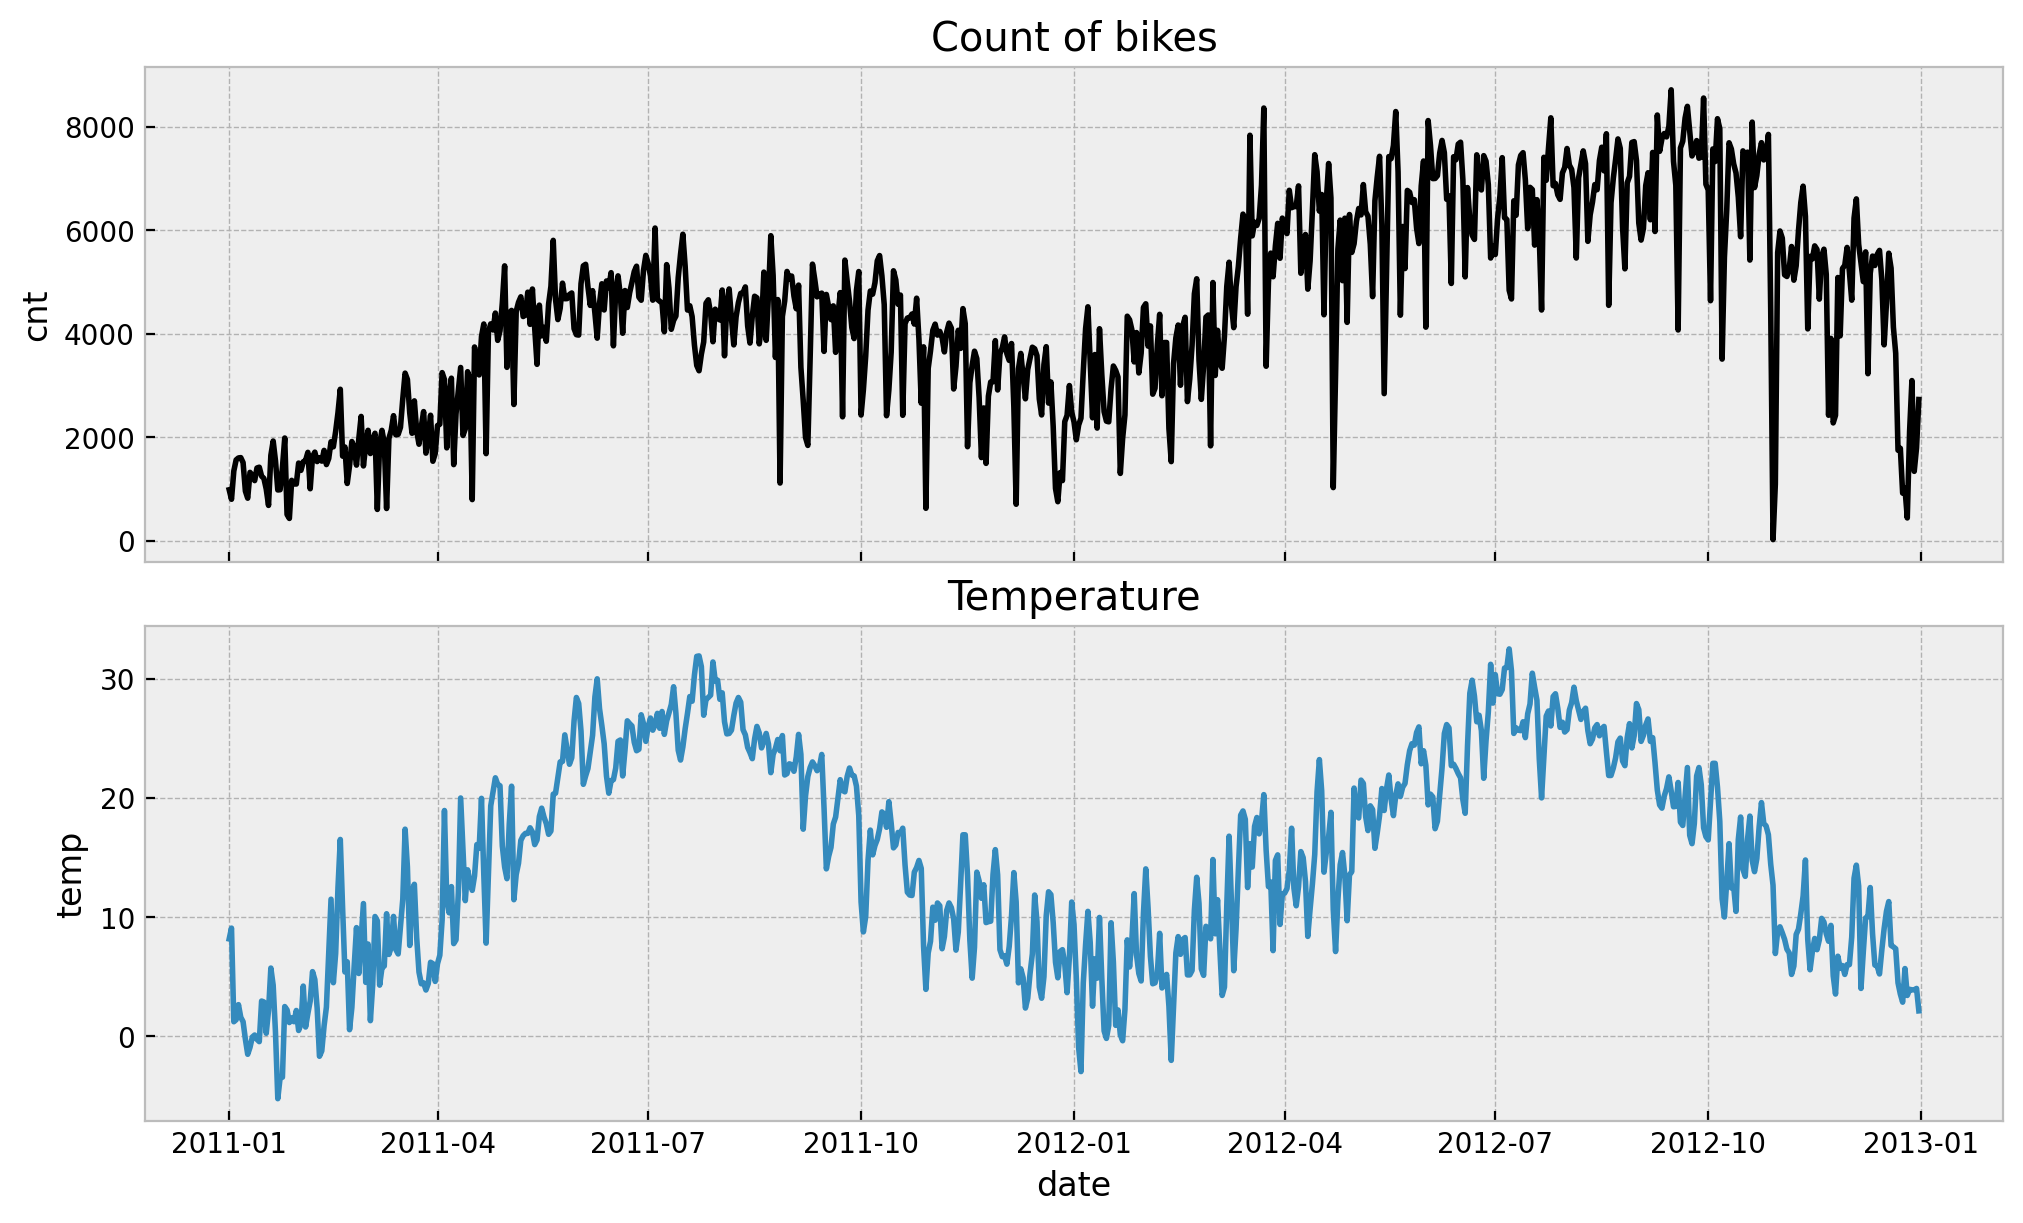

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="cnt", data=data_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=data_df, color="C0", ax=ax[1])
ax[0].set(title="Count of bikes")
ax[1].set(title="Temperature")


As we are going to fit a linear model is always good to scale the data.

In [6]:
target = "cnt"
target_scaled = f"{target}_scaled"

endog_scaler = StandardScaler()
exog_scaler = StandardScaler()


data_df[target_scaled] = endog_scaler.fit_transform(X=data_df[[target]])
data_df[["temp_scaled", "hum_scaled", "windspeed_scaled"]] = exog_scaler.fit_transform(
    X=data_df[["temp", "hum", "windspeed"]]
)


Finally, we extract the features we want to include in the model.

In [7]:
n = data_df.shape[0]
# target
cnt = data_df[target].to_numpy()
cnt_scaled = data_df[target_scaled].to_numpy()
# date feature
date = data_df["date"].to_numpy()
# model regressors
temp_scaled = data_df["temp_scaled"].to_numpy()
hum_scaled = data_df["hum_scaled"].to_numpy()
windspeed_scaled = data_df["windspeed_scaled"].to_numpy()
holiday_idx, holiday = data_df["holiday"].factorize(sort=True)
workingday_idx, workingday = data_df["workingday"].factorize(sort=True)
weathersit_idx, weathersit = data_df["weathersit"].factorize(sort=True)
t = data_df["days_since_2011"].to_numpy() / data_df["days_since_2011"].max()

## Base Model

Before we jump into the time-varying coefficient model let us fist fit a baseline regression model. Let us follow the [bayesian workflow](https://arxiv.org/abs/2011.01808) for model development.

### 1. Model Specification

In a first step (after EDA and data pre-processing) we define the model structure. In particular we choose 

1. **Prior** distributions for the regression coefficients and the noise.
2. **Model parametrization**, i.e. the structure of the linear model. Note that for the categorical variables we use a [`ZeroSumNormal`](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.ZeroSumNormal.html) since we are adding an intercept term. 
3. **Likelihood function**, which is this case we decide for a [StudentT](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.StudentT.html) distribution.

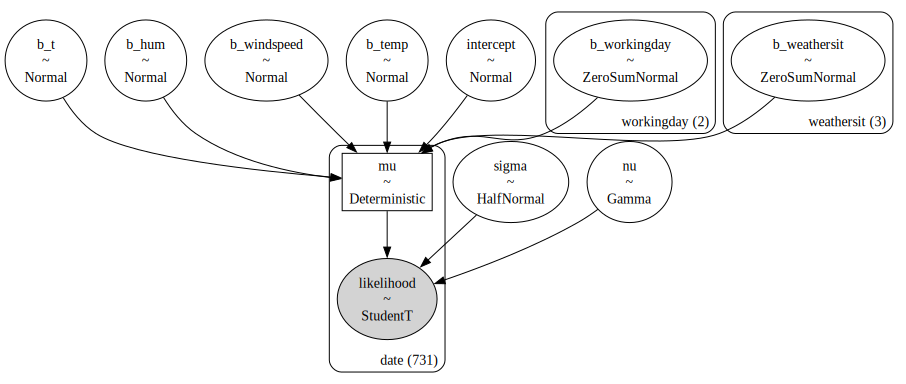

In [8]:
coords = {
    "date": date,
    "workingday": workingday,
    "weathersit": weathersit,
}


with pm.Model(coords=coords) as base_model:
    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_temp = pm.Normal(name="b_temp", mu=0, sigma=1)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=1)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=1)
    b_workingday = pm.ZeroSumNormal(name="b_workingday", sigma=1, dims="workingday")
    b_weathersit = pm.ZeroSumNormal(name="b_weathersit", sigma=1, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=1)

    # --- model parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + b_temp * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )


pm.model_to_graphviz(base_model)

### 2. Prior Predictive Analysis

We can analyze what the model *expects* before seeing the data.

Sampling: [b_hum, b_t, b_temp, b_weathersit, b_windspeed, b_workingday, intercept, likelihood, nu, sigma]


[Text(0.5, 1.0, 'Base Model - Prior Predictive Samples'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt_scaled')]

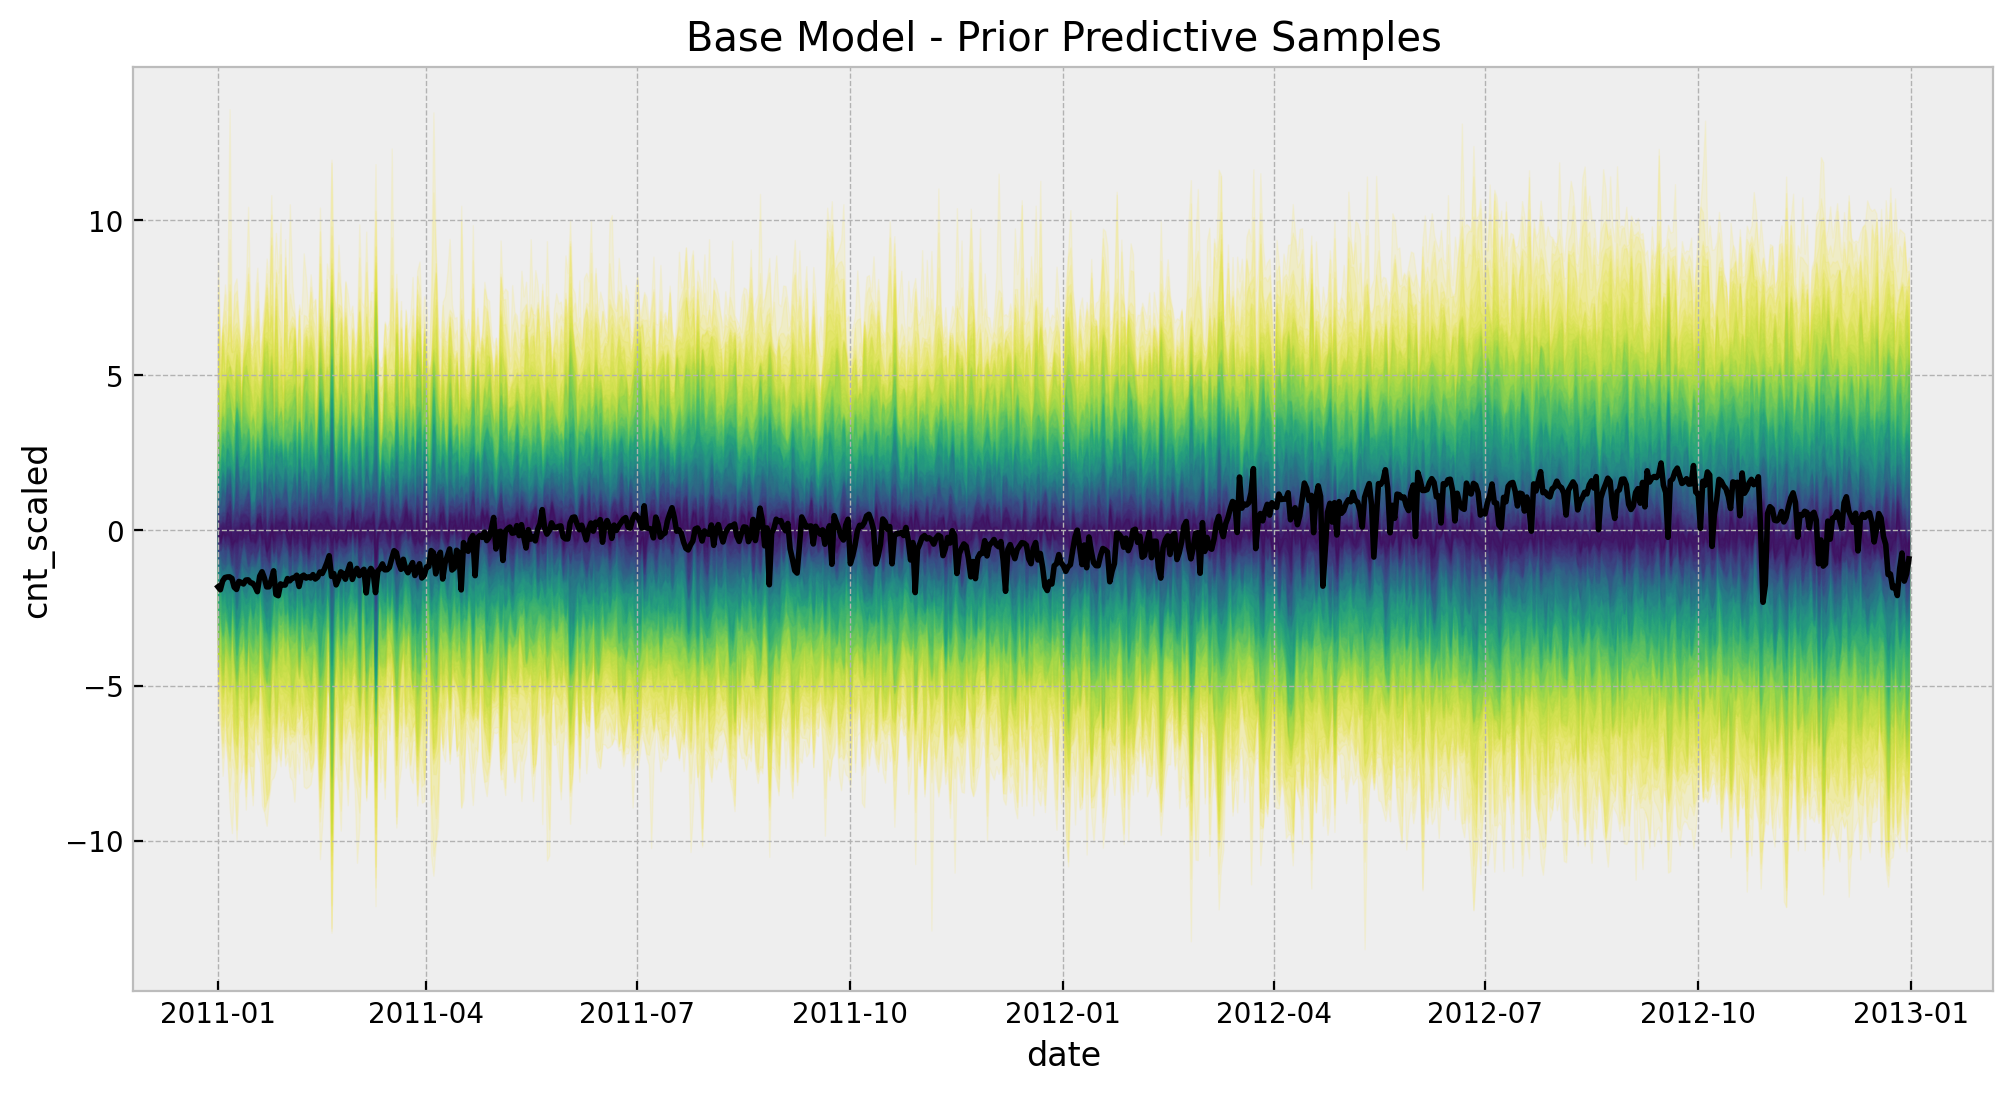

In [9]:
with base_model:
    # --- prior samples ---
    prior_predictive_base = pm.sample_prior_predictive(samples=200, random_seed=rng)


palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(12, 6))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], p, axis=1
    )
    lower = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Base Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=target_scaled,
)

The chosen prior distributions are not very restrictive but they image of the predictions is still within a reasonable range.

### 3. Model Fit

We sample from the posterior distributions using the [JAX based NUTS sampler from Numpyro](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sampling_jax.sample_numpyro_nuts.html).

In [10]:
with base_model:
    idata_base = pm.sample(
        target_accept=0.9,
        draws=2_000,
        chains=5,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=rng,
    )
    posterior_predictive_base = pm.sample_posterior_predictive(trace=idata_base)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:09.875756
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.627567
Transforming variables...
Transformation time =  0:00:01.532368
Computing Log Likelihood...


Sampling: [likelihood]


Log Likelihood time =  0:00:02.468344


In [11]:
# get number of divergences
idata_base["sample_stats"]["diverging"].sum().item()


0

### 4. Model Diagnostics

Now wee look into some diagnostics metrics an plots.

In [12]:
az.summary(data=idata_base, var_names=["~mu"])

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                     -1.254  0.048  -1.346   -1.168      0.001   
b_temp                         0.511  0.017   0.479    0.543      0.000   
b_hum                         -0.114  0.021  -0.154   -0.074      0.000   
b_windspeed                   -0.099  0.017  -0.132   -0.067      0.000   
b_t                            1.992  0.057   1.889    2.103      0.001   
b_workingday[NO WORKING DAY]  -0.033  0.018  -0.066    0.001      0.000   
b_workingday[WORKING DAY]      0.033  0.018  -0.001    0.066      0.000   
b_weathersit[GOOD]             0.373  0.044   0.290    0.455      0.001   
b_weathersit[MISTY]            0.192  0.039   0.117    0.266      0.000   
b_weathersit[RAIN/SNOW/STORM] -0.565  0.074  -0.706   -0.427      0.001   
nu                             3.732  0.553   2.770    4.777      0.006   
sigma                          0.352  0.017   0.321    0.385      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                        0.001    4510.0    5180.0    1.0  
b_temp                           0.000    9669.0    7452.0    1.0  
b_hum                            0.000    7430.0    6426.0    1.0  
b_windspeed                      0.000    8704.0    6782.0    1.0  
b_t                              0.000    8325.0    7553.0    1.0  
b_workingday[NO WORKING DAY]     0.000   11109.0    7781.0    1.0  
b_workingday[WORKING DAY]        0.000   11109.0    7781.0    1.0  
b_weathersit[GOOD]               0.000    4696.0    6277.0    1.0  
b_weathersit[MISTY]              0.000    6345.0    6895.0    1.0  
b_weathersit[RAIN/SNOW/STORM]    0.001    4745.0    5745.0    1.0  
nu                               0.005    7705.0    6823.0    1.0  
sigma                            0.000    7682.0    7289.0    1.0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Base Model - Trace')

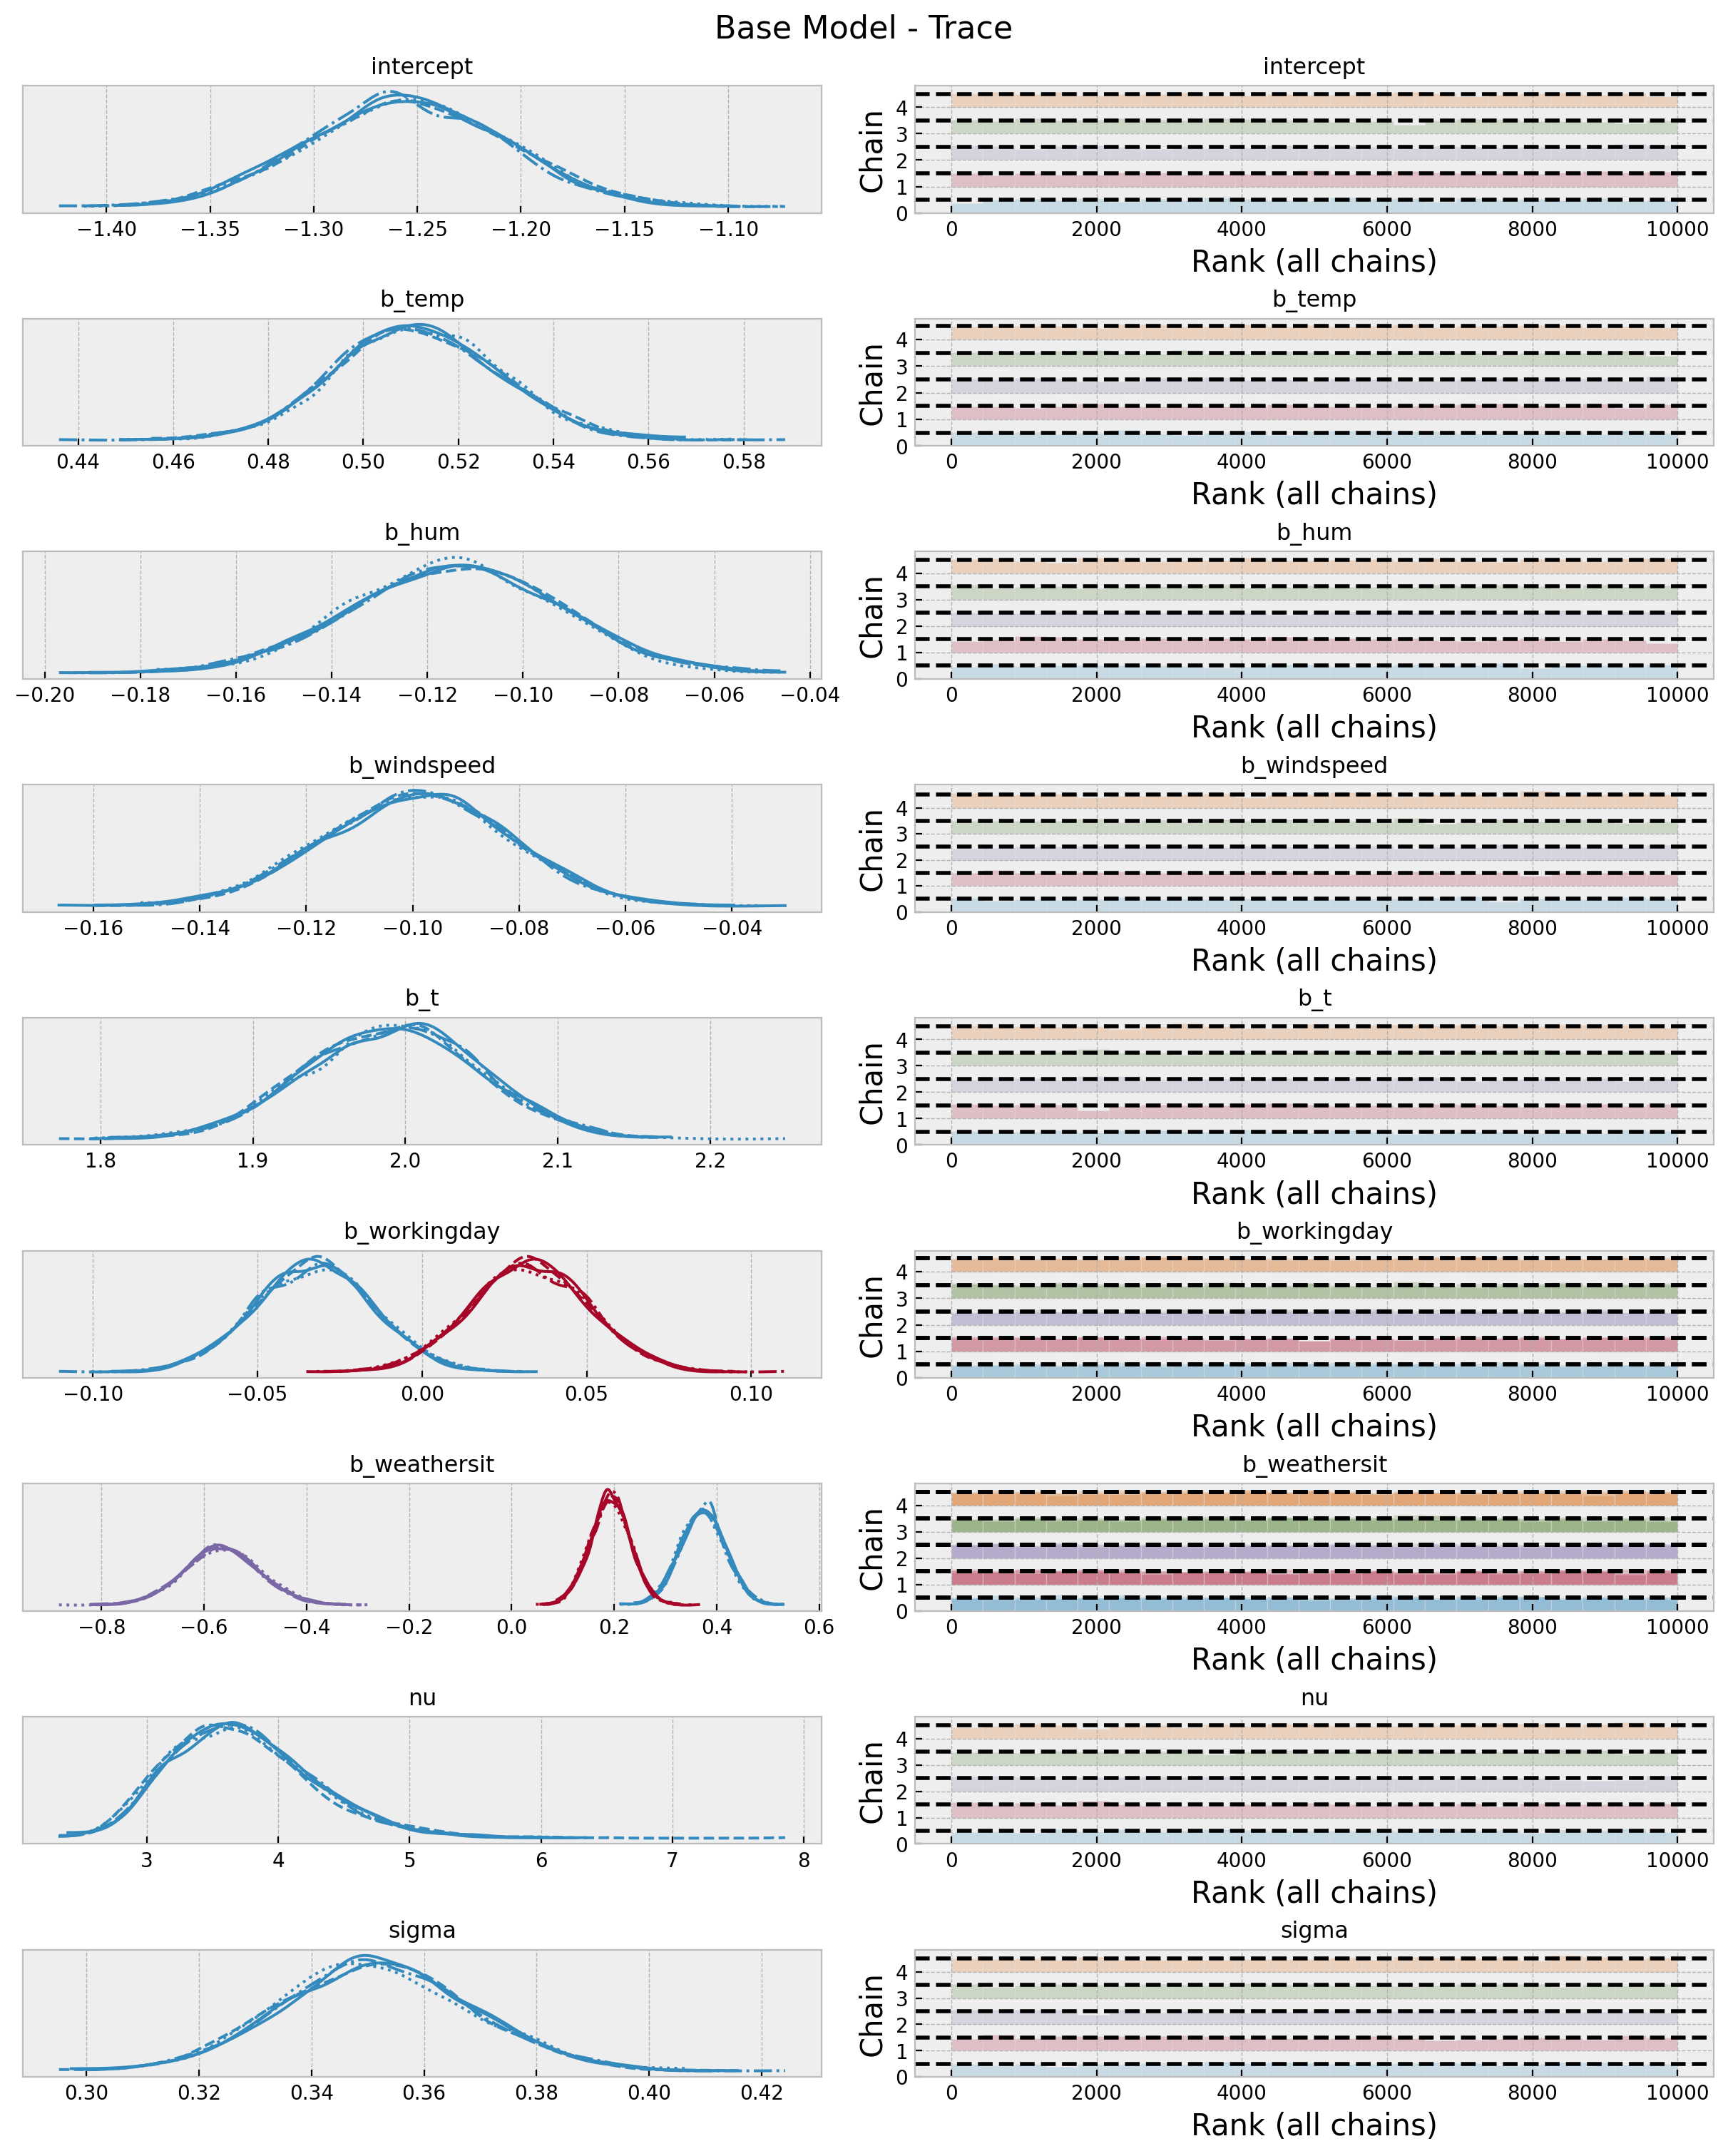

In [13]:
axes = az.plot_trace(
    data=idata_base,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Base Model - Trace", fontsize=16)


Overall, the model looks good.

Text(0.5, 0.98, 'Base Model - Posterior Distributions')

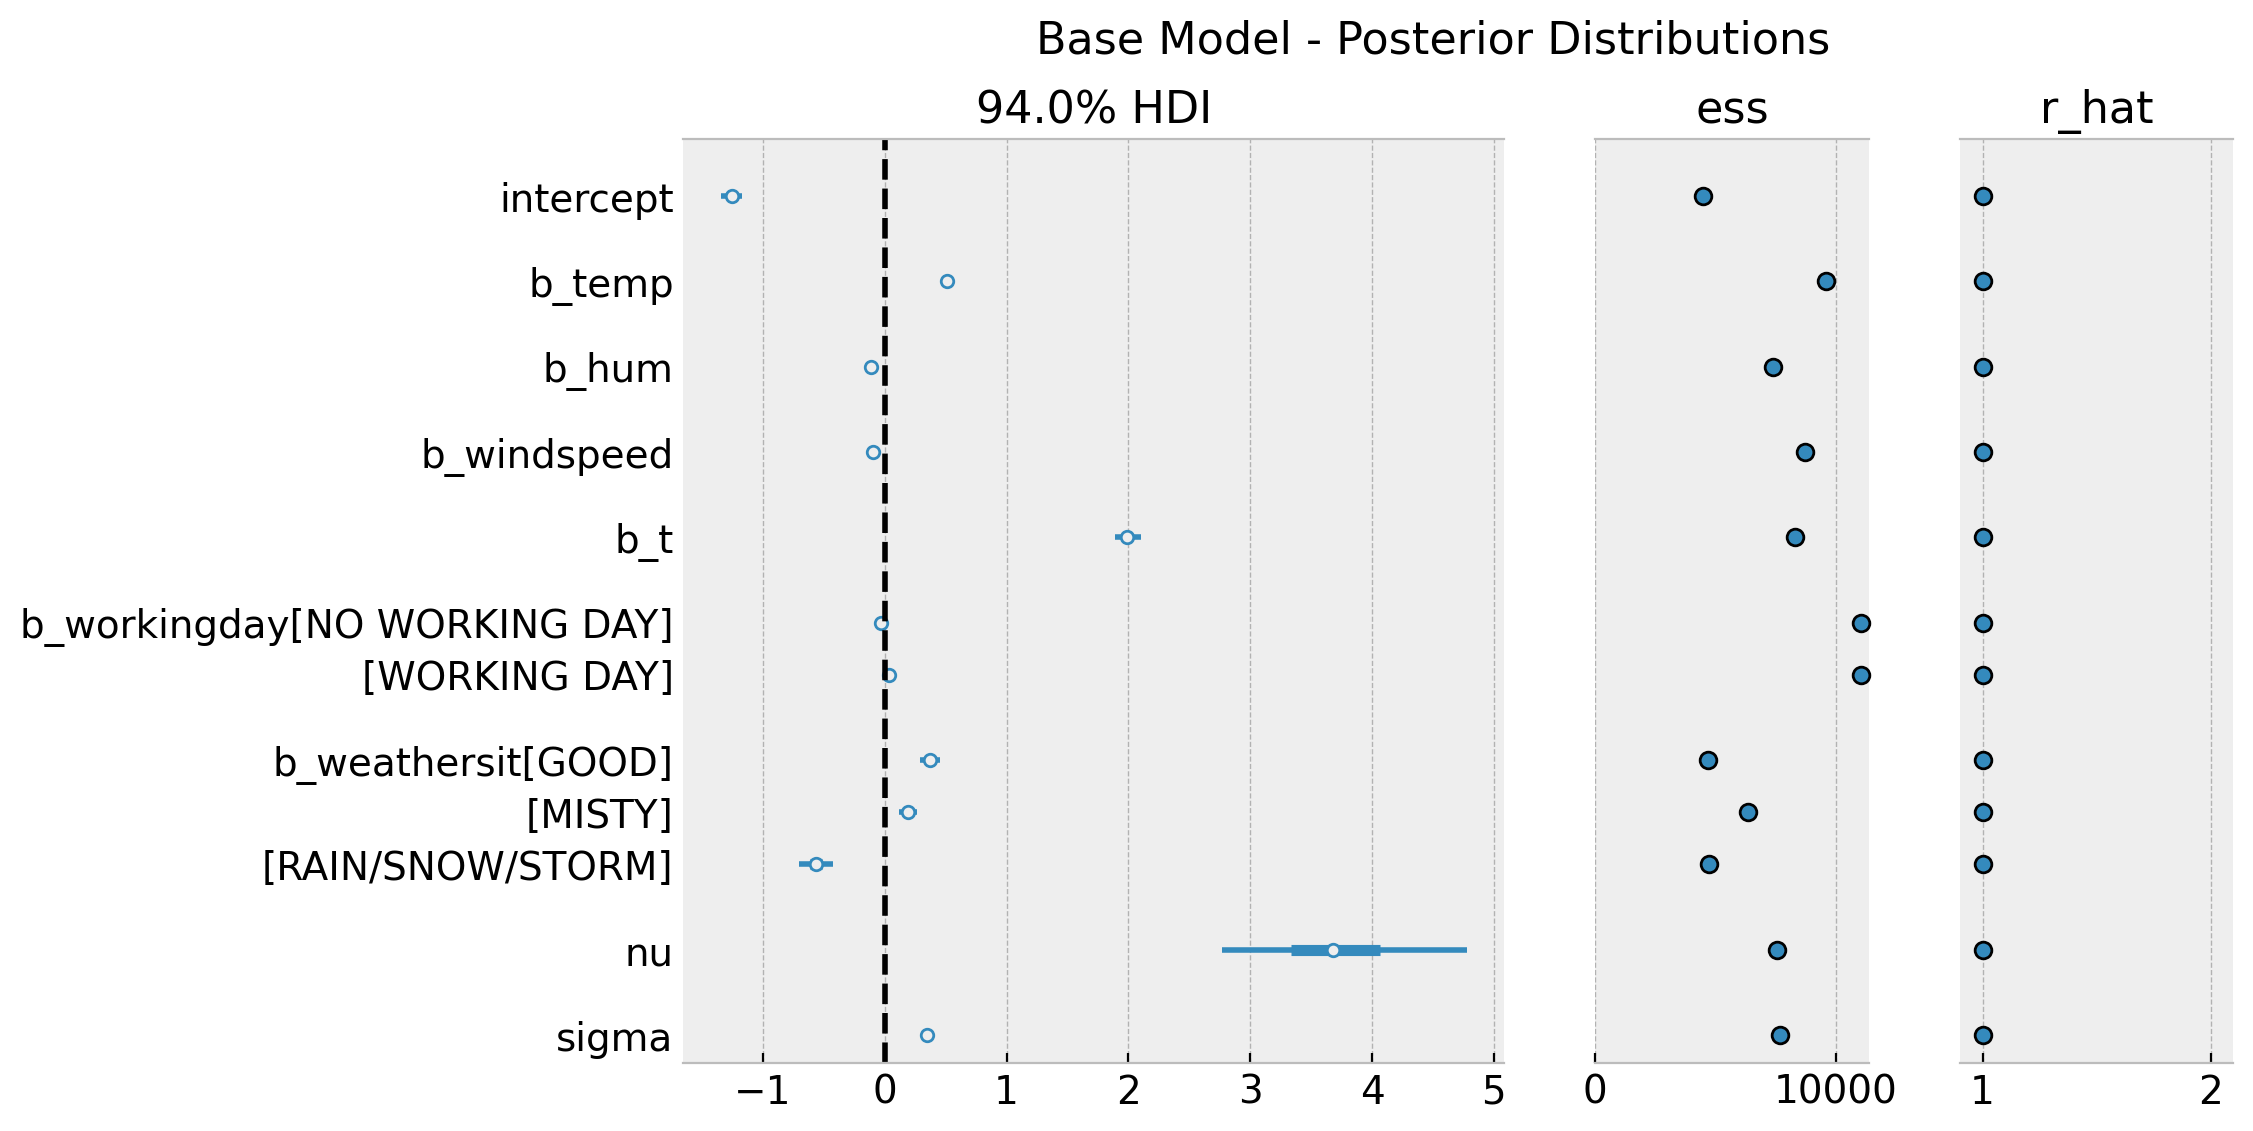

In [14]:
axes = az.plot_forest(
    data=idata_base,
    var_names=["~mu"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(10, 6),
)
axes[0].axvline(x=0.0, color="black", linestyle="--")
plt.gcf().suptitle("Base Model - Posterior Distributions", fontsize=16)


Note that in this base model the temperature feature has a positive effect on bike rentals on average.

### 5. Posterior Predictive Distribution

Finally, let us take a look at the fitted values.

[Text(0.5, 1.0, 'Base Model - Posterior Predictive Samples'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt')]

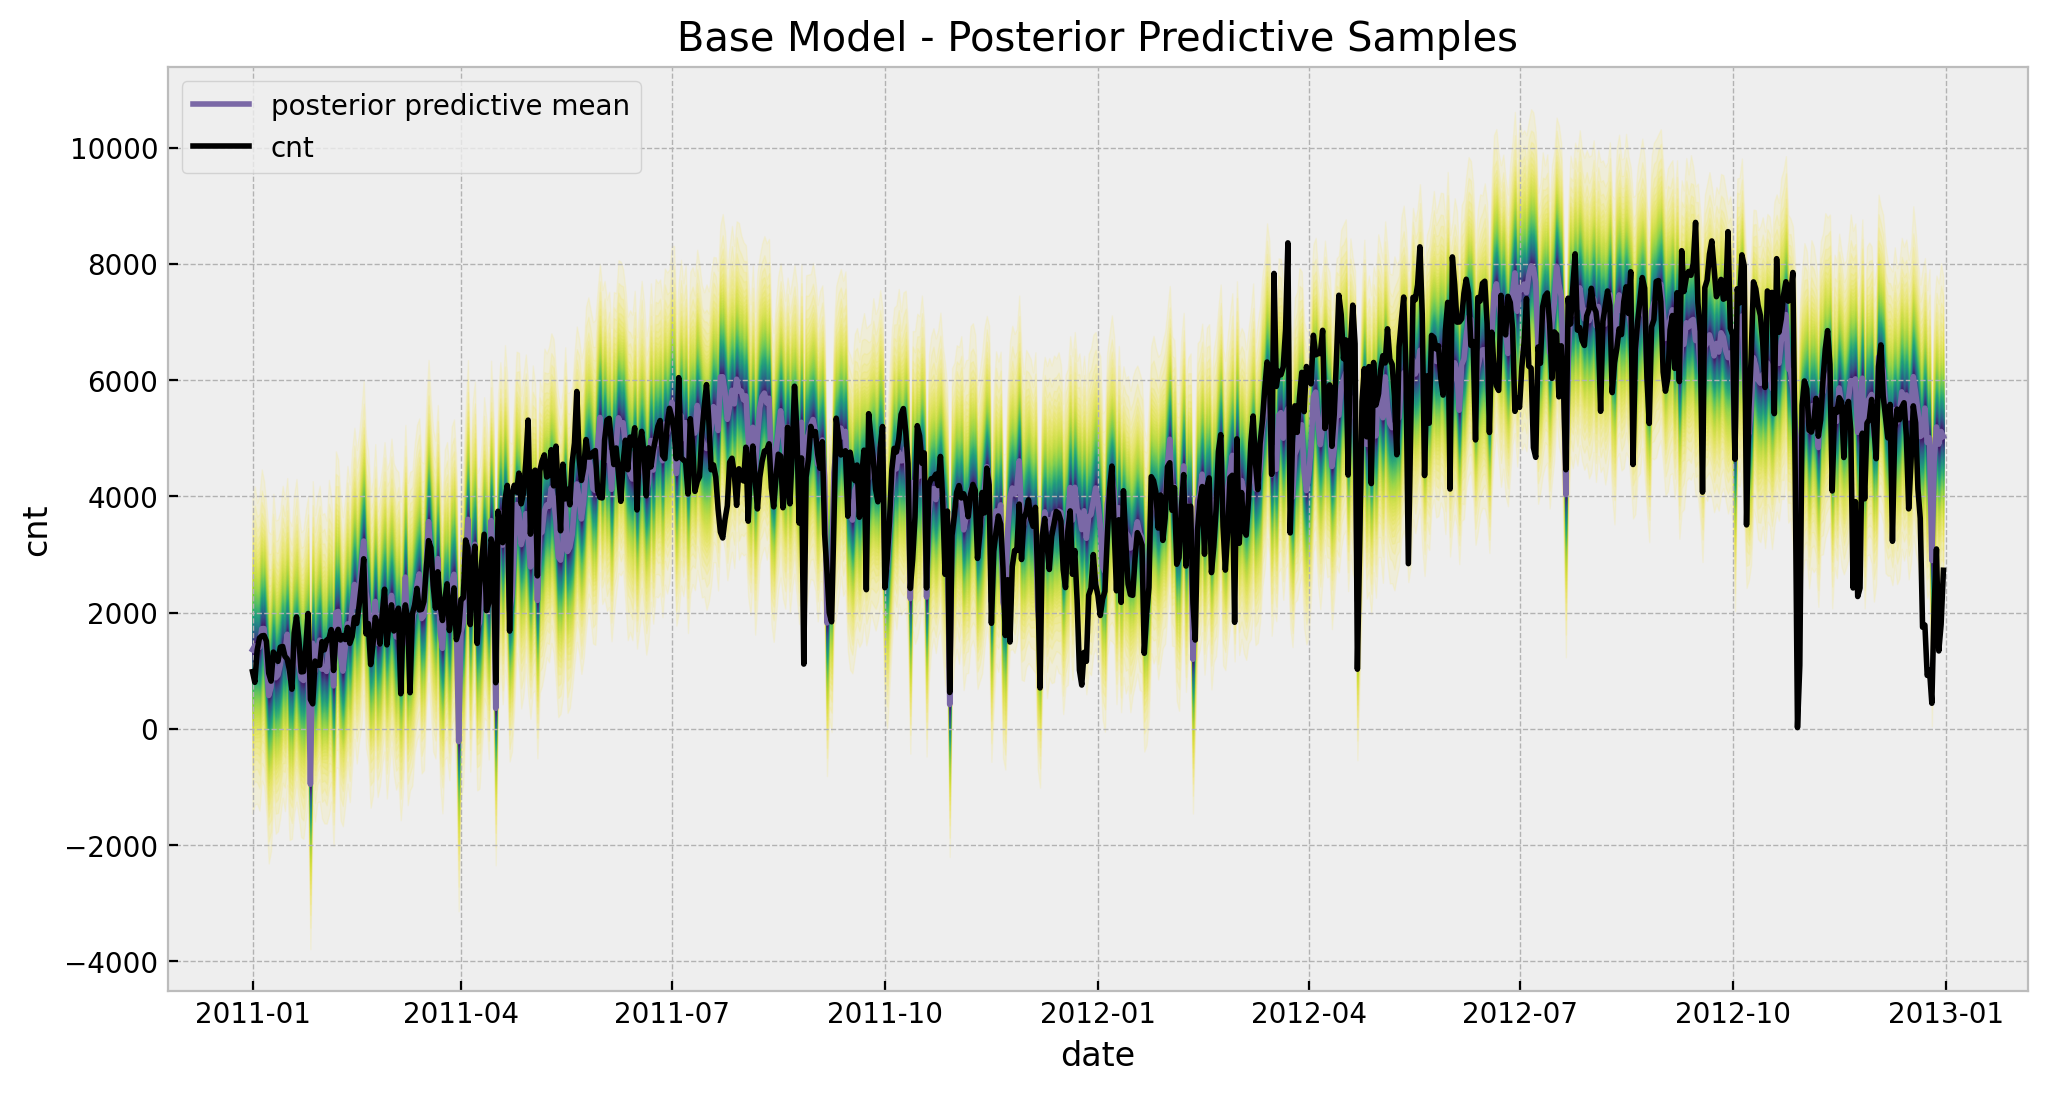

In [15]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive_base.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood.to_numpy()
)

fig, ax = plt.subplots(figsize=(12, 6))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt,
    color="black",
    label=target,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title="Base Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=target,
)


Observe that for certain points in July the predictions and the fit do not coincide and go in opposite directions. This will be solved by adding the time-varying coefficient to the linear model for the temperature regressor (see below).

**Remark**: Note that the model predict negative values for the bike rentals. This is of course not good! An alterative choice of likelihood to model count data would resolve this (e.g. Poisson or Negative Binomial likelihoods).

## Time-Varying Coefficients Model

We now follow the same workflow above. The main difference is that we replace the regression coefficient of the temperature with  [GaussianRandomWalk](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.GaussianRandomWalk.html).

### 1. Model Specification

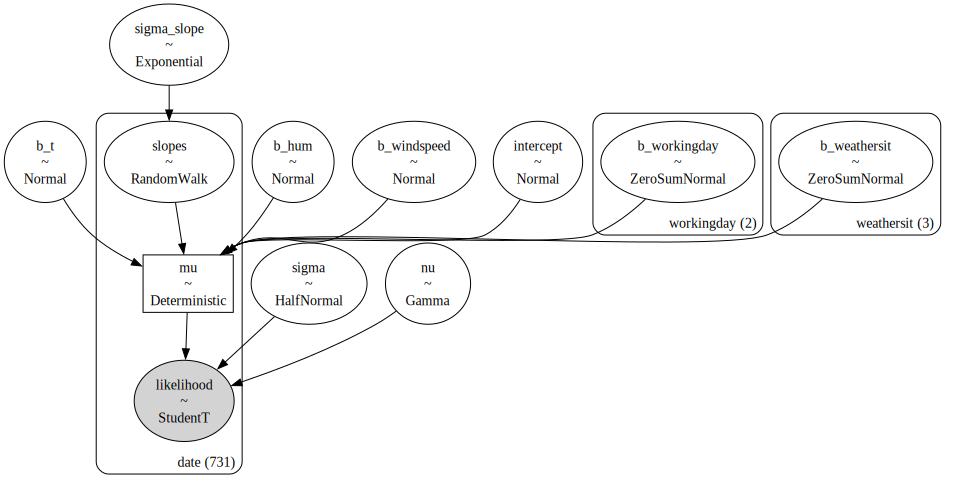

In [16]:
with pm.Model(coords=coords) as model:
    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=1)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=1)
    b_workingday = pm.ZeroSumNormal(name="b_workingday", sigma=1, dims="workingday")
    b_weathersit = pm.ZeroSumNormal(name="b_weathersit", sigma=1, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    sigma_slopes = pm.Exponential(name="sigma_slope", lam=1 / 0.2)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=1)

    # --- model parametrization ---
    slopes = pm.GaussianRandomWalk(
        name="slopes",
        sigma=sigma_slopes,
        init_dist=Exponential.dist(lam=1 / 2),
        dims="date",
    )
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + slopes * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )


pm.model_to_graphviz(model)


### 2. Prior Predictive Analysis

Sampling: [b_hum, b_t, b_weathersit, b_windspeed, b_workingday, intercept, likelihood, nu, sigma, sigma_slope, slopes]


[Text(0.5, 1.0, 'Time-Varying Coefficient Model - Prior Predictive Samples'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt_scaled')]

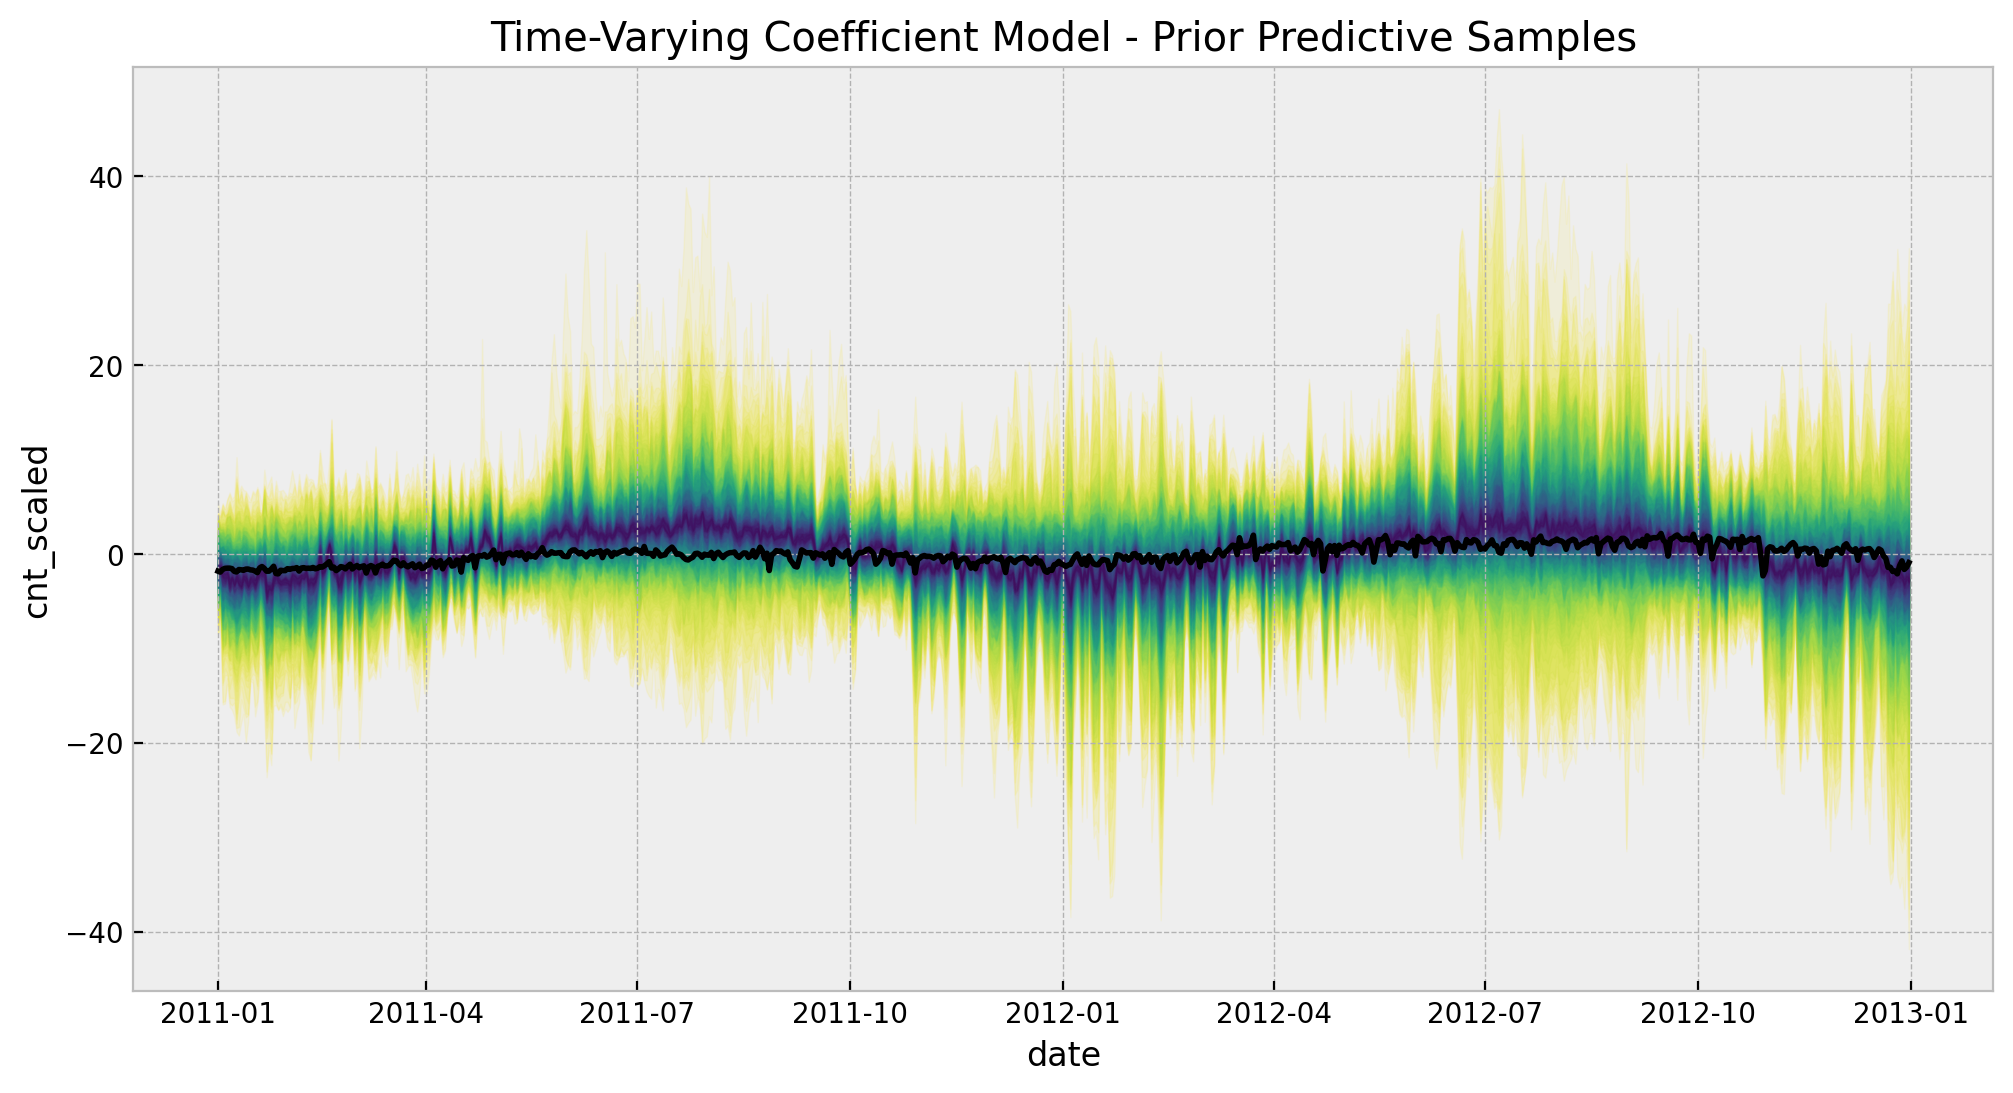

In [17]:
with model:
    # --- prior samples ---
    prior_predictive = pm.sample_prior_predictive(samples=200, random_seed=rng)


palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(12, 6))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Time-Varying Coefficient Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=target_scaled,
)


### 3. Model Fit

In [18]:
with model:
    idata = pm.sample(
        target_accept=0.97,
        draws=2_000,
        chains=5,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:10.769068
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:45.150495
Transforming variables...
Transformation time =  0:00:01.350294
Computing Log Likelihood...


Sampling: [likelihood]


Log Likelihood time =  0:00:02.346486


In [19]:
# get number of divergences
idata["sample_stats"]["diverging"].sum().item()


3

### 4. Model Diagnostics

In [20]:
az.summary(data=idata, var_names=["~mu", "~slopes"])


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                     -1.144  0.058  -1.251   -1.032      0.002   
b_hum                         -0.180  0.019  -0.215   -0.144      0.000   
b_windspeed                   -0.115  0.013  -0.138   -0.090      0.000   
b_t                            2.359  0.086   2.198    2.518      0.003   
b_workingday[NO WORKING DAY]  -0.019  0.013  -0.043    0.007      0.000   
b_workingday[WORKING DAY]      0.019  0.013  -0.007    0.043      0.000   
b_weathersit[GOOD]             0.336  0.038   0.263    0.406      0.000   
b_weathersit[MISTY]            0.183  0.032   0.119    0.241      0.000   
b_weathersit[RAIN/SNOW/STORM] -0.519  0.063  -0.637   -0.398      0.001   
sigma_slope                    0.108  0.015   0.082    0.137      0.001   
nu                             3.646  0.561   2.649    4.670      0.006   
sigma                          0.225  0.015   0.197    0.251      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                        0.001    1450.0    3692.0   1.00  
b_hum                            0.000    5372.0    7588.0   1.00  
b_windspeed                      0.000   10597.0    8009.0   1.00  
b_t                              0.002    1152.0    2486.0   1.01  
b_workingday[NO WORKING DAY]     0.000    8022.0    7981.0   1.00  
b_workingday[WORKING DAY]        0.000    8022.0    7981.0   1.00  
b_weathersit[GOOD]               0.000    8405.0    6915.0   1.00  
b_weathersit[MISTY]              0.000   11460.0    8240.0   1.00  
b_weathersit[RAIN/SNOW/STORM]    0.000    9725.0    6504.0   1.00  
sigma_slope                      0.001     329.0     504.0   1.01  
nu                               0.004    7770.0    7747.0   1.00  
sigma                            0.000    1285.0    3669.0   1.00

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['slopes'] have not been found and will be ignored
  warnings.warn(


Text(0.5, 0.98, 'Time-Varying Coefficient Model - Trace')

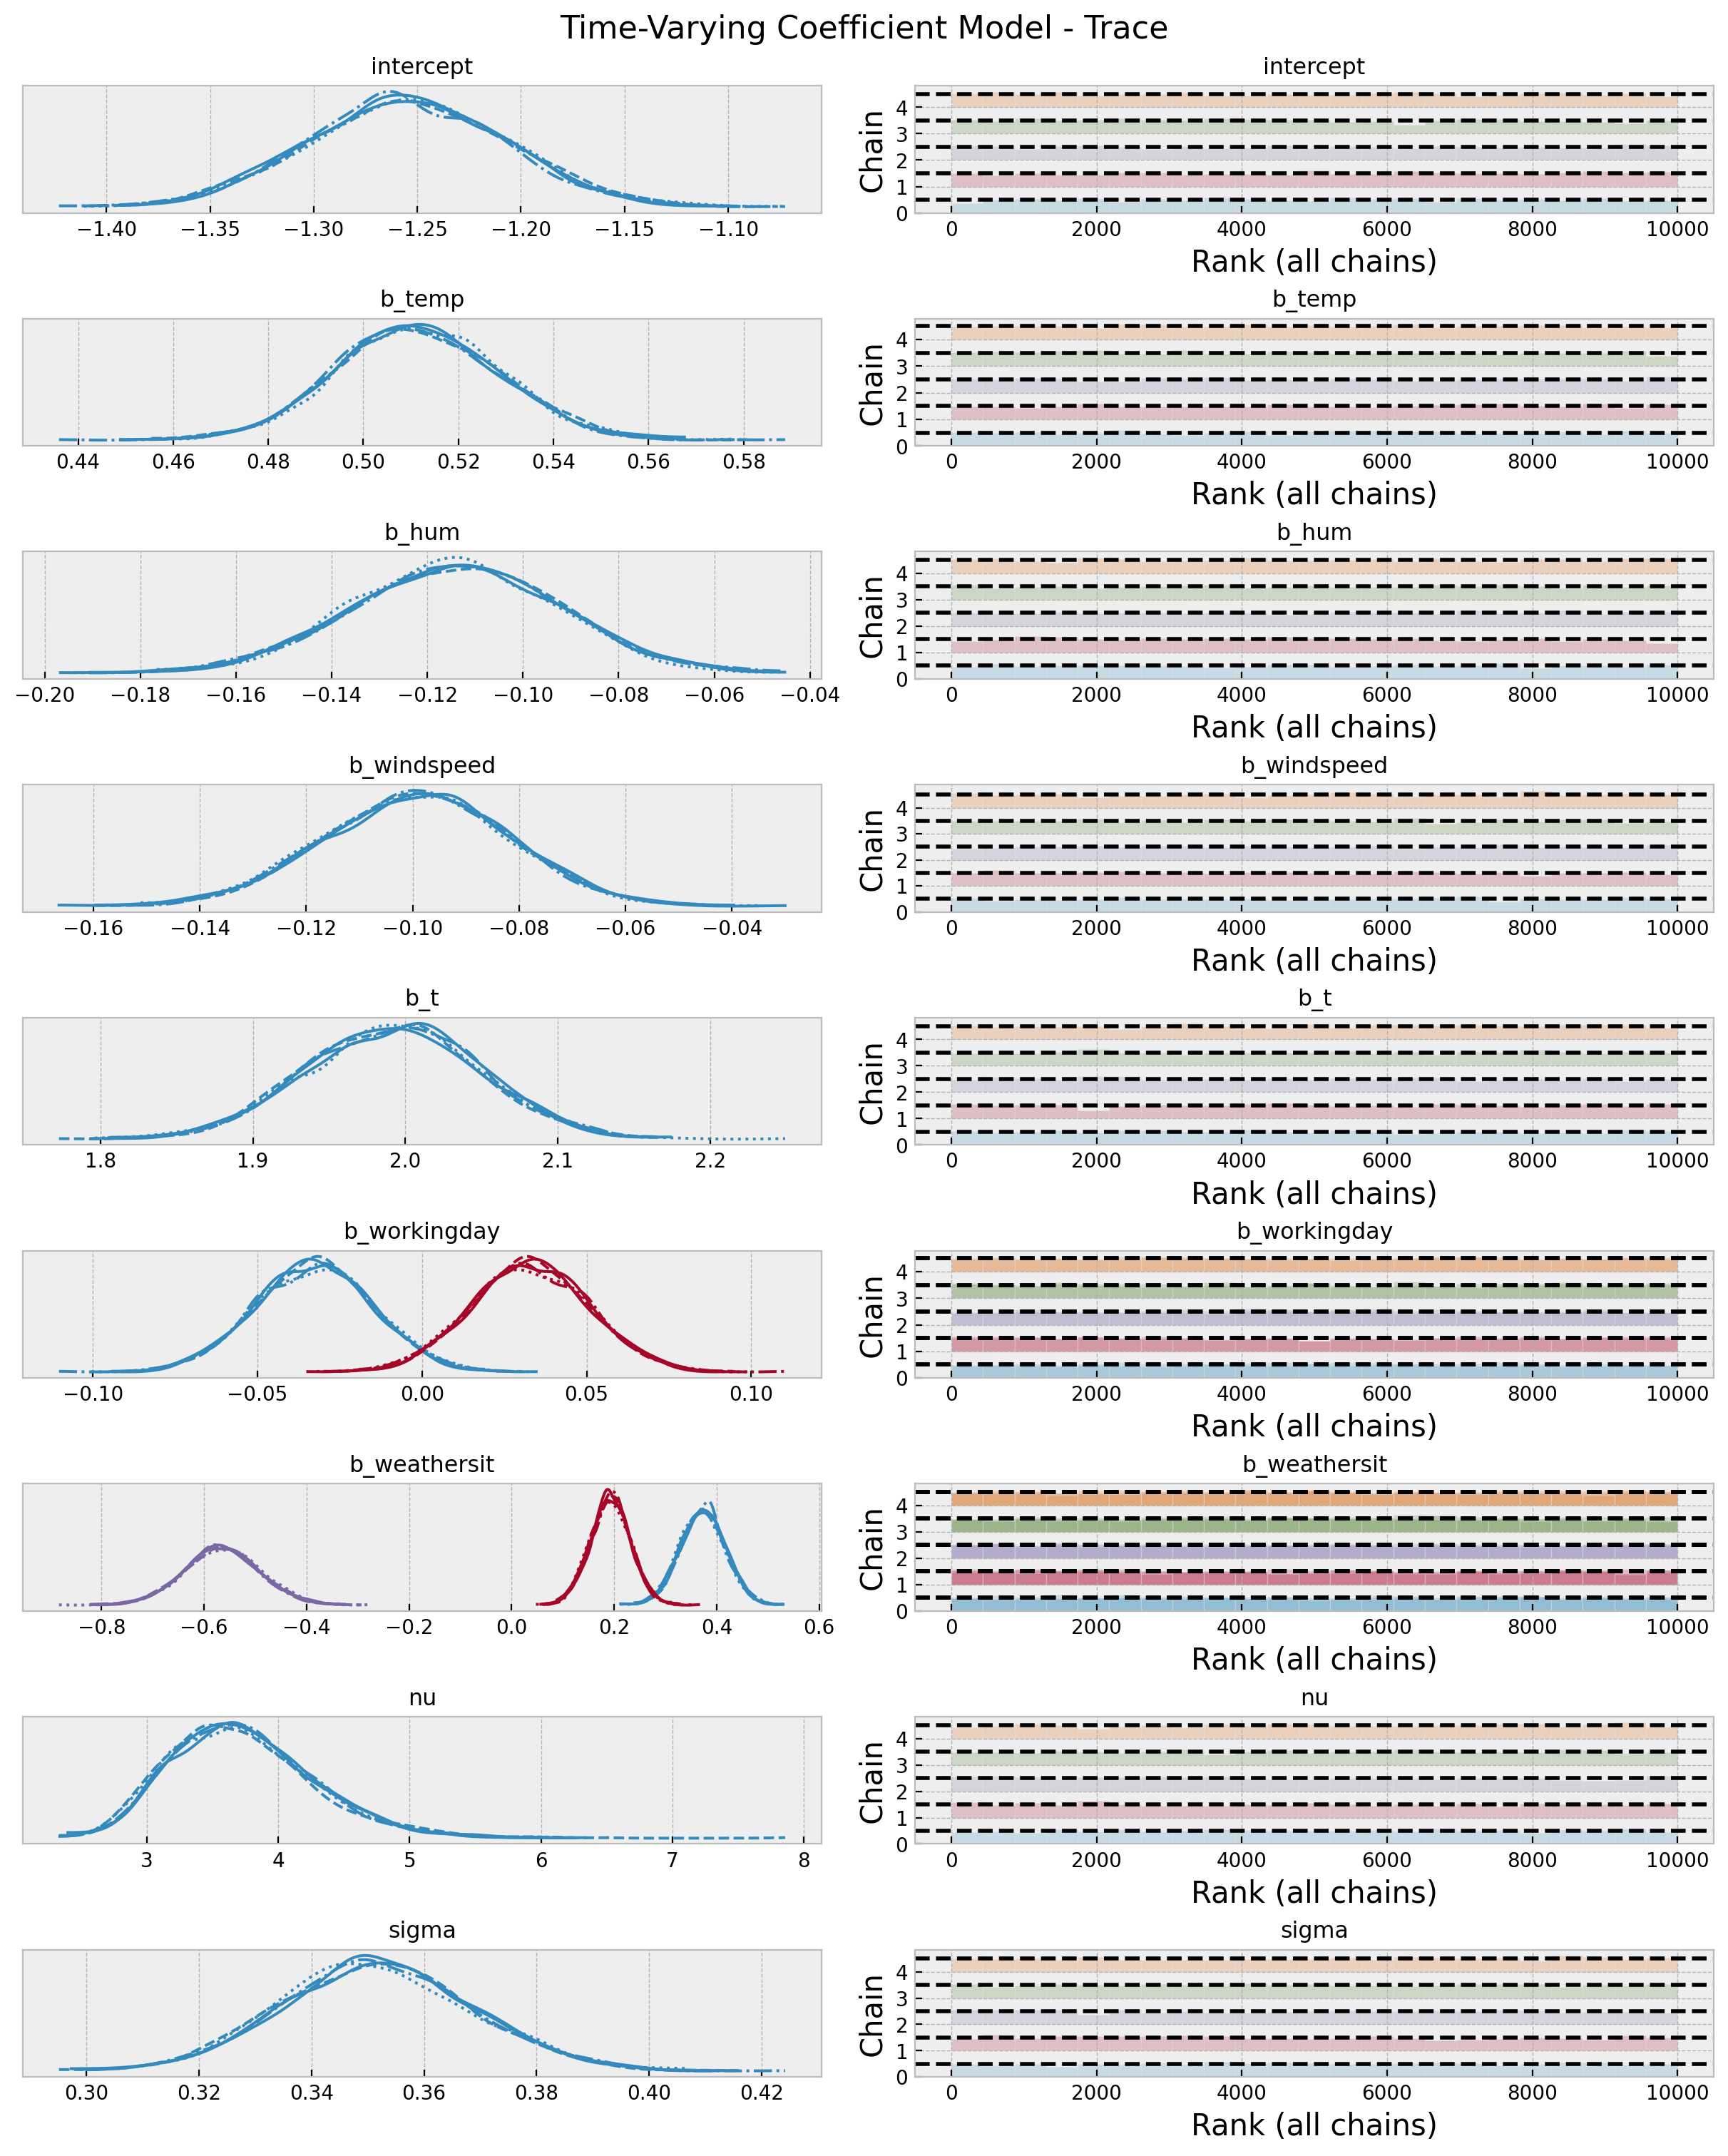

In [21]:
axes = az.plot_trace(
    data=idata_base,
    var_names=["~mu", "~slopes"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Time-Varying Coefficient Model - Trace", fontsize=16)

Let us now compare the two models in a forest plot.

Text(0.5, 0.98, 'Posterior Distributions')

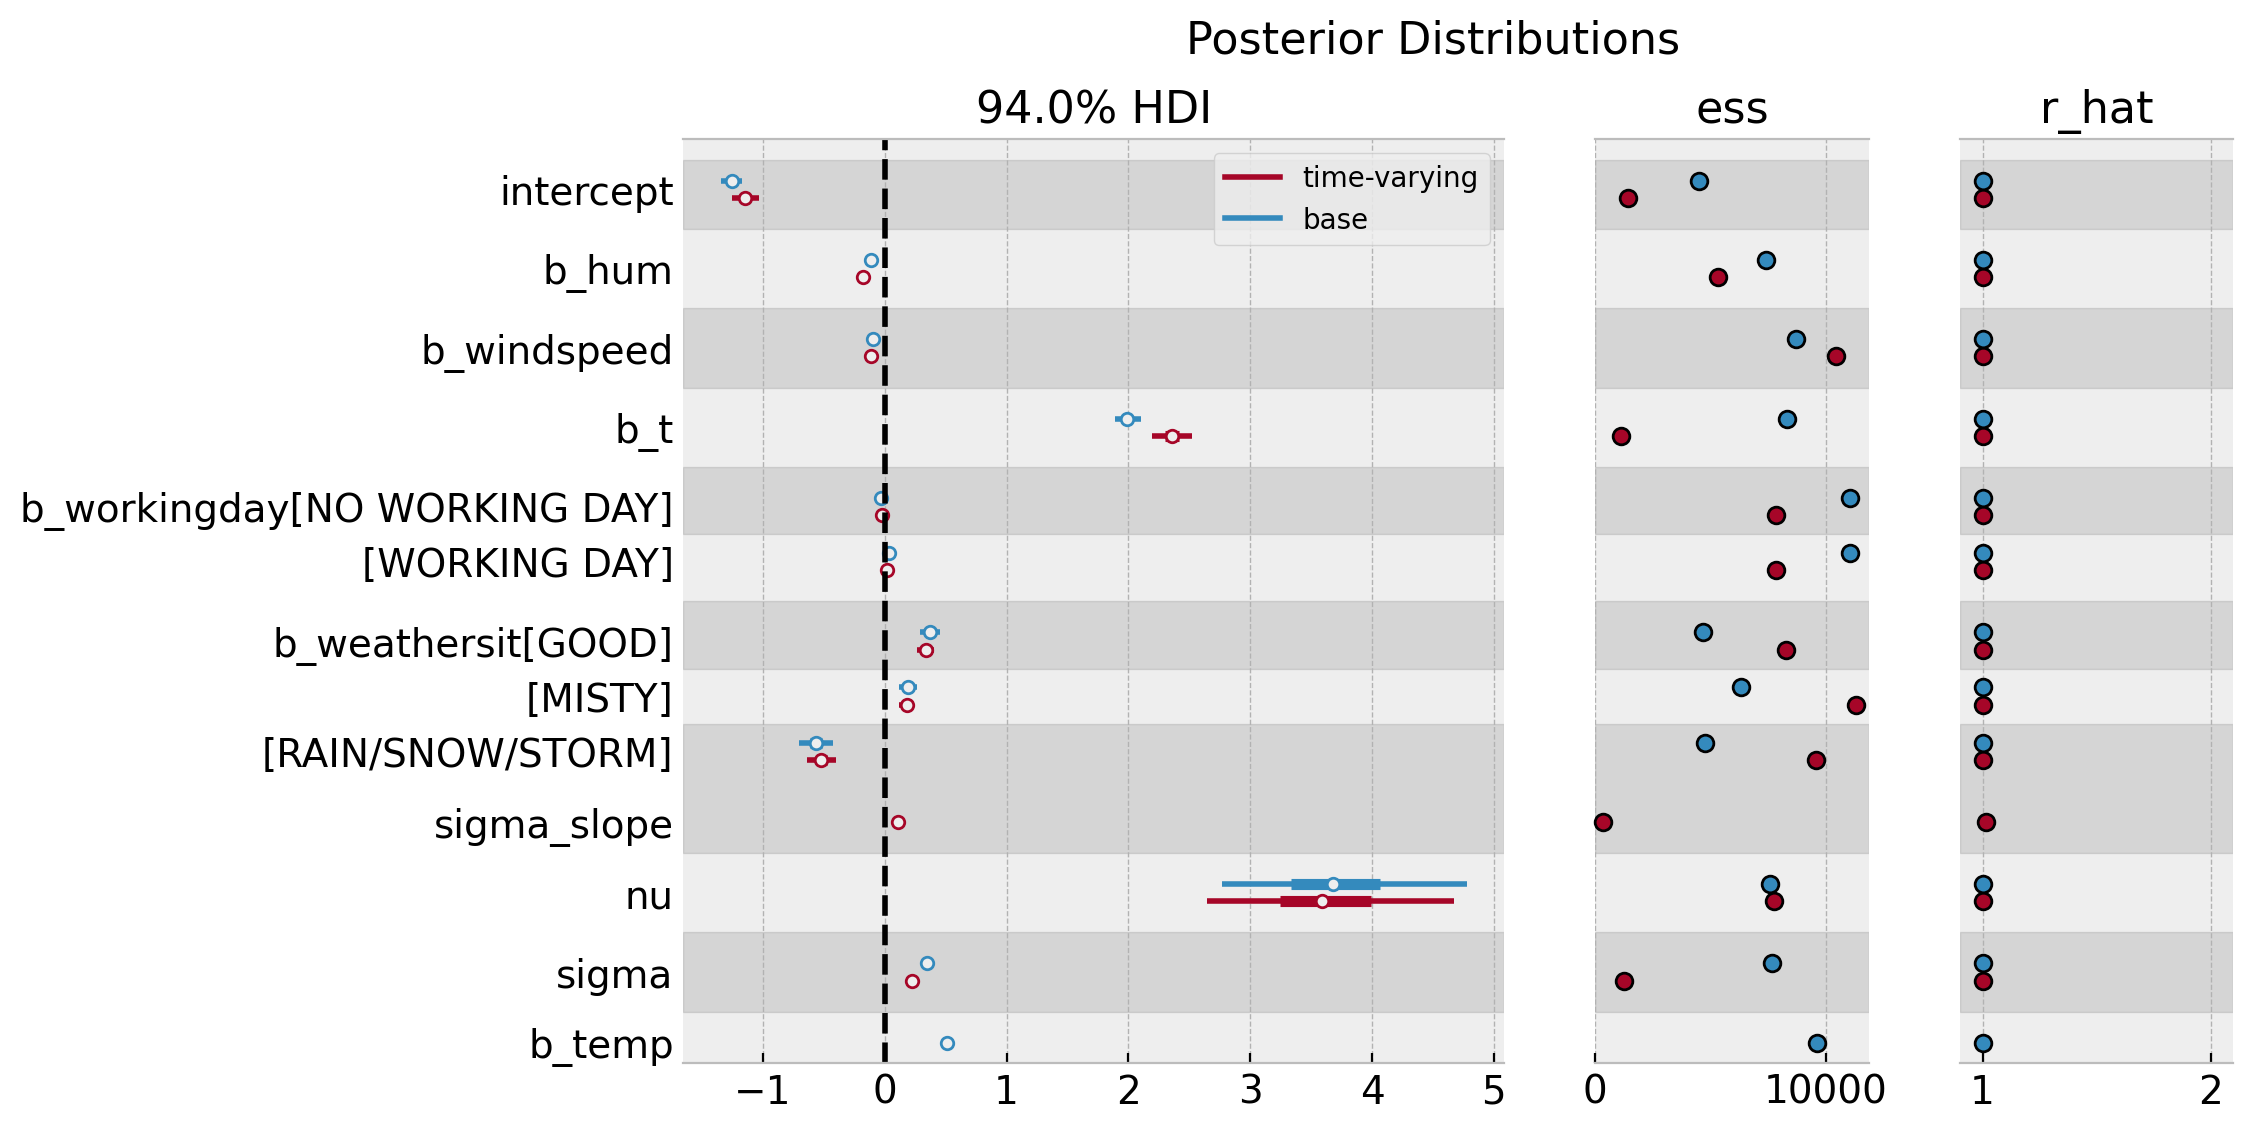

In [22]:
axes = az.plot_forest(
    data=[idata_base, idata],
    model_names=["base", "time-varying"],
    var_names=["~mu", "~slopes"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(10, 6),
)
axes[0].axvline(x=0.0, color="black", linestyle="--")
plt.gcf().suptitle("Posterior Distributions", fontsize=16)


Overall, there is no major change in the estimated regression coefficients besides the trend component.

We can also use the [`az.compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_compare.html) method to compare the two models.

In [23]:
az.compare(compare_dict={"base": idata_base, "time-varying": idata})

rank    elpd_loo       p_loo   elpd_diff   weight         se  \
time-varying     0 -234.681624  130.992277    0.000000  0.99113  26.205748   
base             1 -488.805000   10.651760  254.123376  0.00887  26.755164   

                    dse  warning scale  
time-varying   0.000000    False   log  
base          22.925291    False   log

It seems that the time-varying coefficient model is better at predicting the bike rentals.

### 5. Posterior Predictive Distribution

[Text(0.5, 1.0, 'Time-Varying Coefficient Model - Posterior Predictive Samples'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt')]

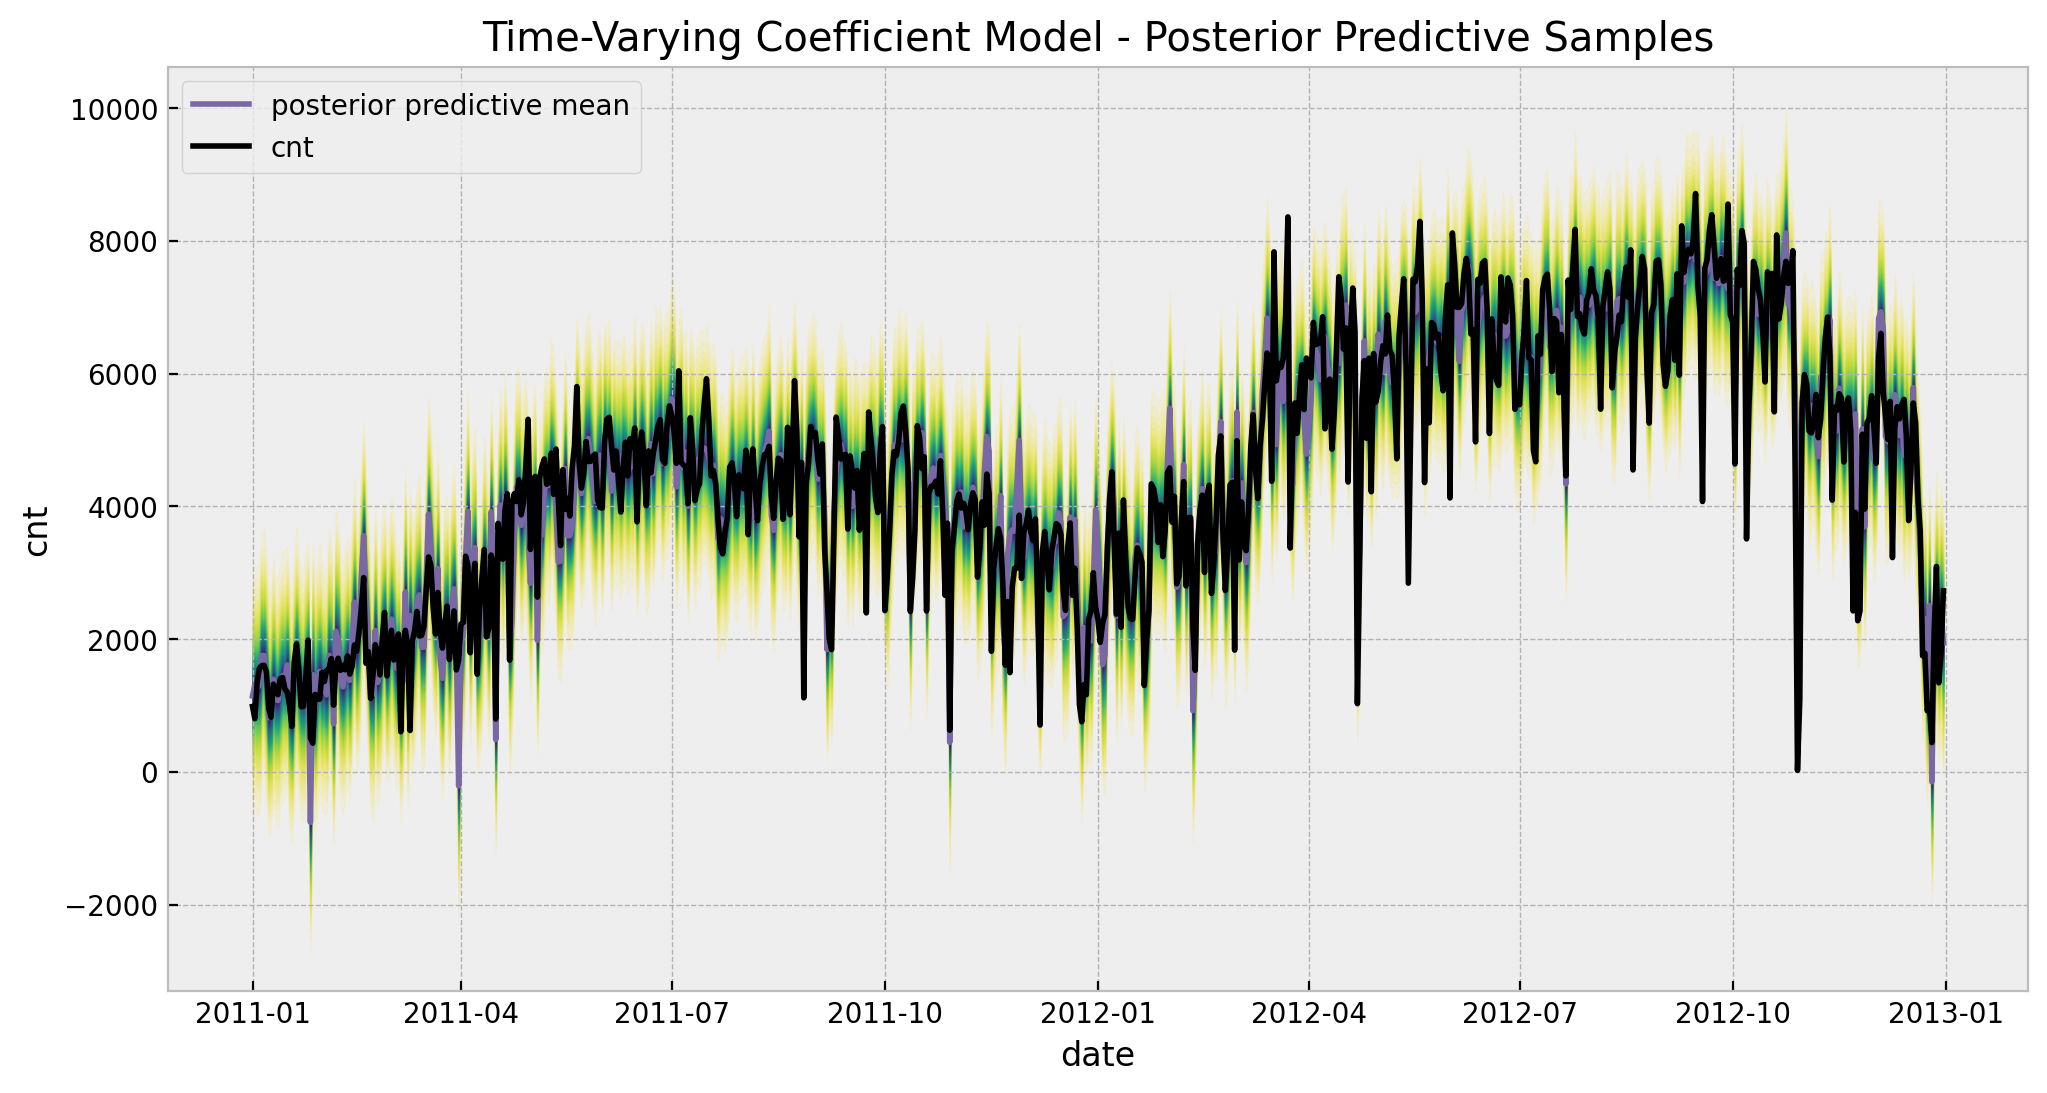

In [24]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood.to_numpy()
)

fig, ax = plt.subplots(figsize=(12, 6))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt,
    color="black",
    label=target,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title="Time-Varying Coefficient Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=target,
)


### 6. Temperature Effect Deep-Dive

Next, we wan to compare the  inferred temperature effect from both models. To begin with, let us compare the mean effect for both models. 

In [25]:
base_tmp_mean = (
    idata_base.posterior["b_temp"].stack(sample=("chain", "draw")).to_numpy().mean()
)
time_varying_tmp_mean = (
    idata.posterior["slopes"].stack(sample=("chain", "draw")).to_numpy().mean()
)
print(
    f"""
base model mean effect = {base_tmp_mean: 0.3f}
------------------------------------------
time-varying model mean effect  = {time_varying_tmp_mean: 0.3f}
------------------------------------------
"""
)


base model mean effect =  0.511
------------------------------------------
time-varying model mean effect  =  0.612
------------------------------------------



It seems that the effect of the time-varying coefficient model is higher. Still, this is just one statistic.It is always better to see the data. The following plot shows the effect as a function of the temperature.

[Text(0.5, 1.0, 'Temperature Effect'),
 Text(0.5, 0, 'temp'),
 Text(0, 0.5, 'effect')]

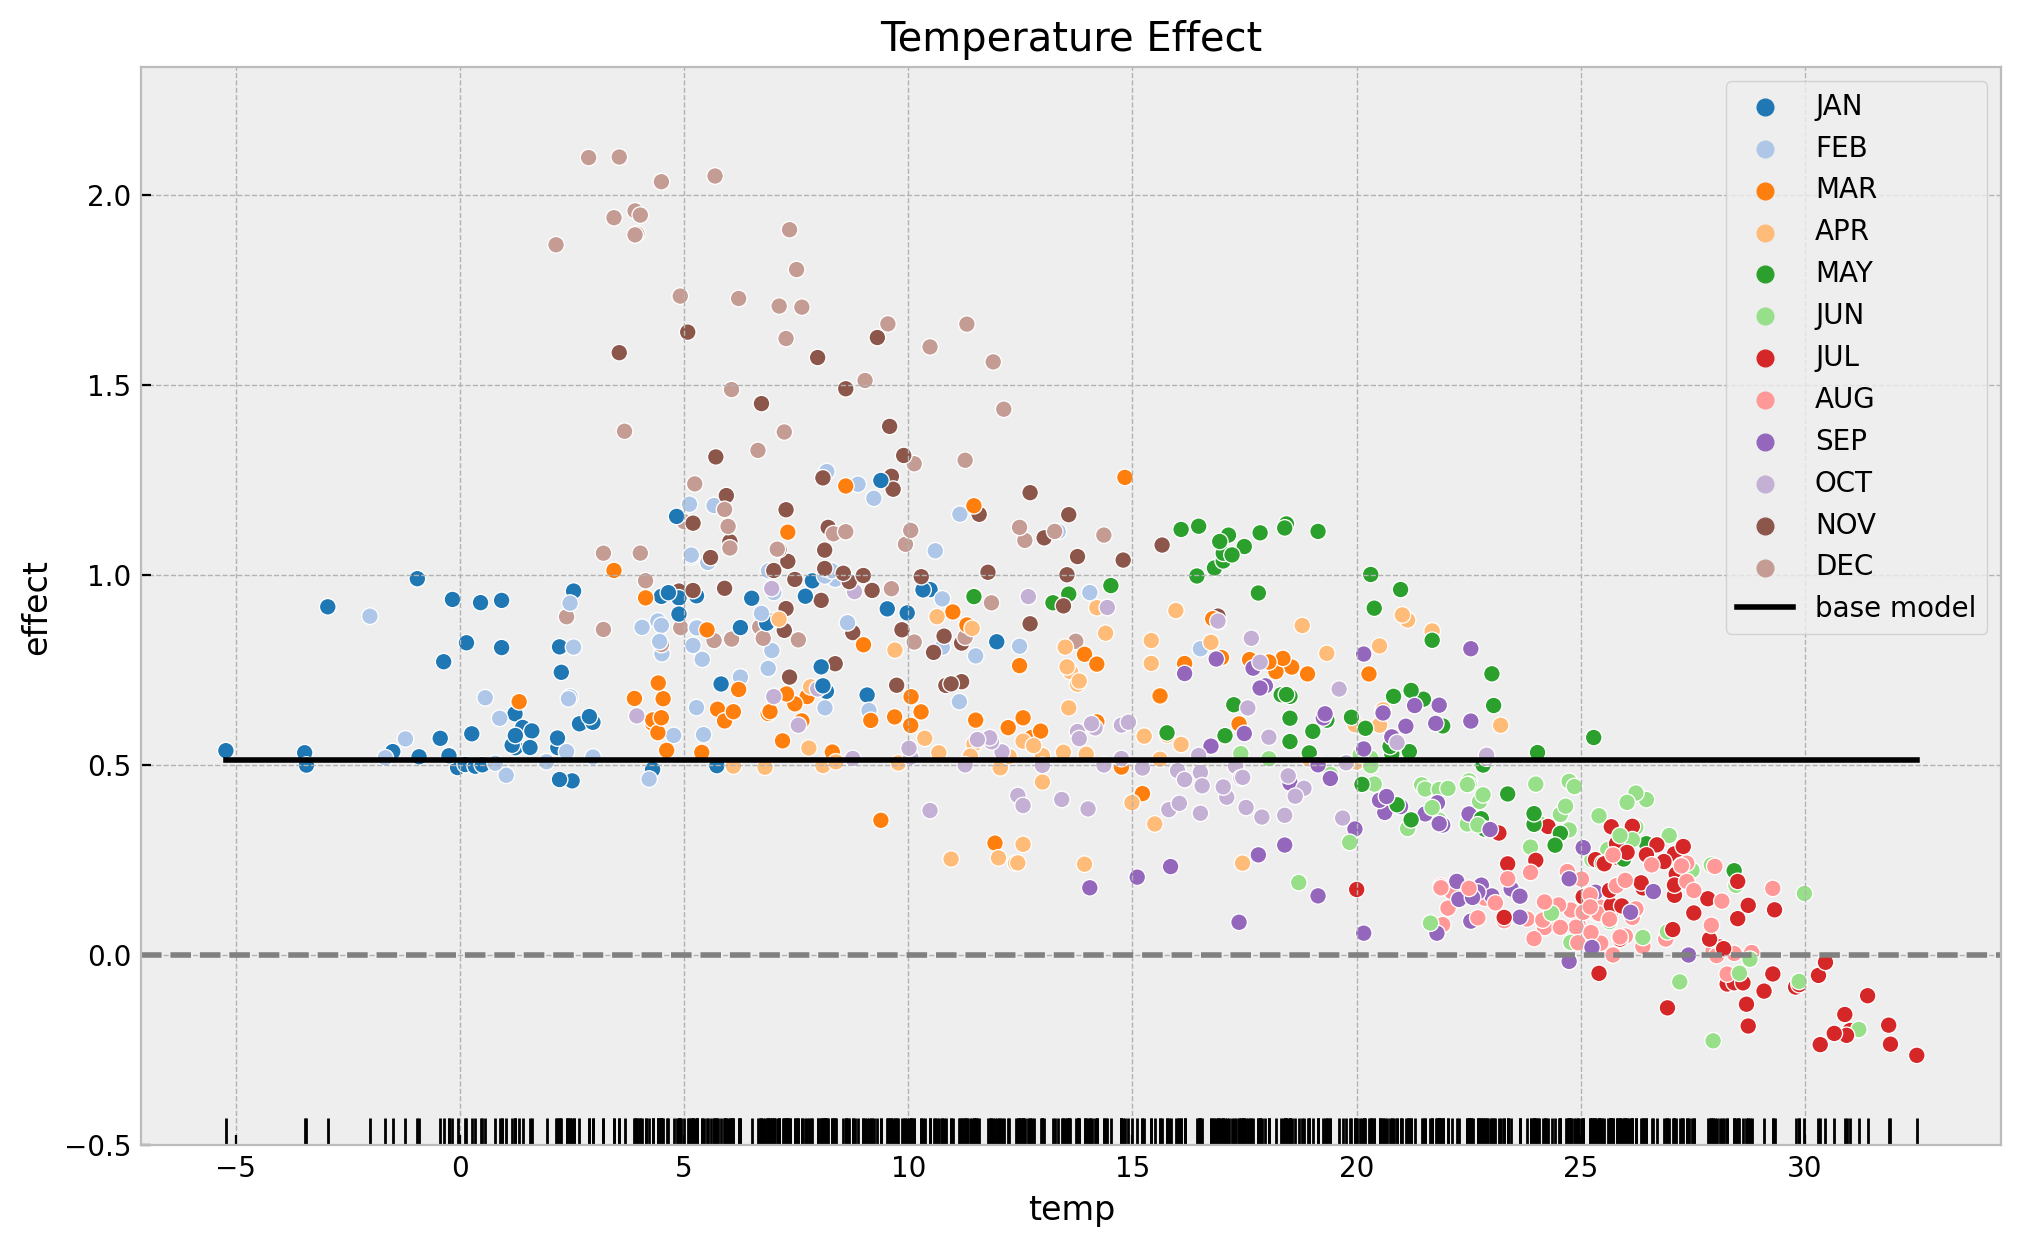

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(
    x="temp",
    y="slopes",
    data=data_df.assign(
        slopes=idata.posterior["slopes"].stack(sample=("chain", "draw")).mean(axis=1)
    ),
    hue="mnth",
    palette="tab20",
)
sns.lineplot(
    x="temp",
    y="b_temp",
    data=data_df.assign(
        b_temp=idata_base.posterior["b_temp"]
        .stack(sample=("chain", "draw"))
        .mean()
        .to_numpy()
    ),
    color="black",
    label="base model",
    ax=ax,
)
sns.rugplot(x=data_df["temp"], color="black", ax=ax)
ax.axhline(y=0.0, color="gray", linestyle="--")
ax.set(title="Temperature Effect", xlabel="temp", ylabel="effect")

We see many interesting features from this plot:
- The time-varying coefficient model indeed finds a non constant effect of temperature on bike rentals.
- The effect of second model is always positive for temperatures lower than $25$ degrees. For higher temperatures the effect is sometimes negative, which is consistent with the results found in the previous post [Exploring Tools for Interpretable Machine Learning](https://juanitorduz.github.io/interpretable_ml/). Ths happens mainly in the months of June and July.
- The variance of the time-varying effect decreases with the temperature.

Finally, let us plot the temperature effect as a function of time.

[Text(0.5, 1.0, 'Temperature')]

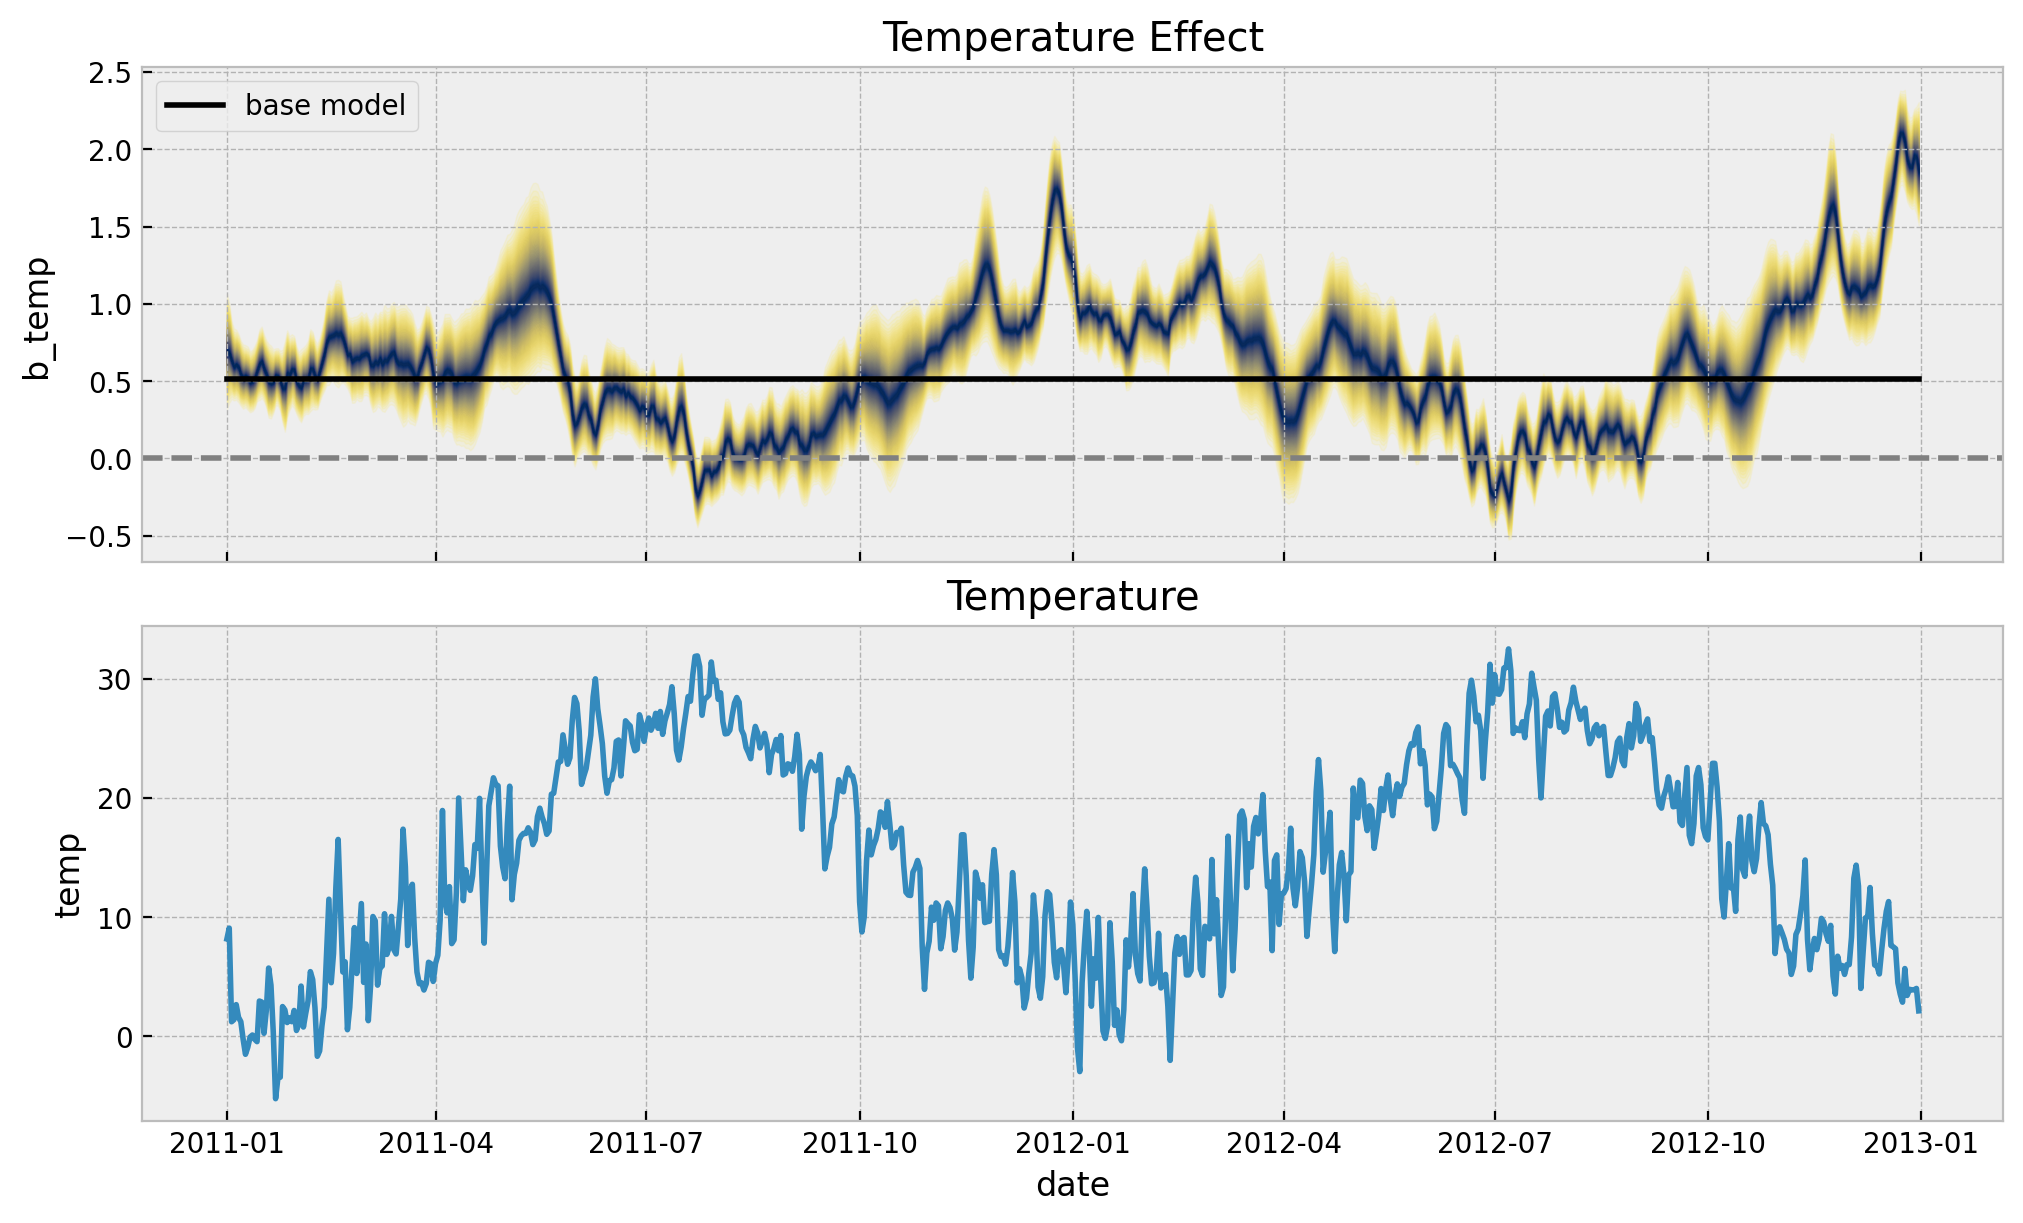

In [27]:
palette = "cividis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_slopes = idata.posterior["slopes"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_slopes, p, axis=1)
    lower = np.percentile(posterior_predictive_slopes, 100 - p, axis=1)
    color_val = colors[i]
    ax[0].fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x="date",
    y="b_temp",
    data=data_df.assign(
        b_temp=idata_base.posterior["b_temp"]
        .stack(sample=("chain", "draw"))
        .mean()
        .to_numpy()
    ),
    color="black",
    label="base model",
    ax=ax[0],
)
ax[0].axhline(y=0.0, color="gray", linestyle="--")
ax[0].legend(loc="upper left")
ax[0].set(title="Temperature Effect")
sns.lineplot(x="date", y="temp", data=data_df, color="C0", ax=ax[1])
ax[1].set(title="Temperature")


We see that the effect is quite seasonal.